## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

from tqdm import tqdm
import time

Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [ ]:
import ipynbname
from pathlib import Path


# Путь к текущему ноутбуку
nb_path = ipynbname.path()
base_dir = nb_path.parent   # папка, где лежит ноутбук
file_path = base_dir / "data" / "data.csv"

data = pd.read_csv(
    file_path, 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [10]:
# Проверяем типы данных в DataFrame
print("Типы данных в DataFrame:")
print(data.dtypes)
print("\n" + "="*50 + "\n")

# Подсчитываем столбцы с числовыми типами (int/float)
numeric_columns = data.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns
num_numeric = len(numeric_columns)

print(f"Столбцы с числовыми типами: {list(numeric_columns)}")
print(f"\nКоличество столбцов с числовыми типами (int/float): {num_numeric}")


Типы данных в DataFrame:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID      object
Country         object
dtype: object


Столбцы с числовыми типами: ['Quantity', 'UnitPrice']

Количество столбцов с числовыми типами (int/float): 2


### Задание 2.2
Выберите столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [11]:
# Проверяем пропуски в указанных столбцах
columns_to_check = ['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

print("Проверка пропусков в указанных столбцах:")
print("="*60)

for col in columns_to_check:
    missing_count = data[col].isna().sum()
    missing_pct = (missing_count / len(data)) * 100
    has_missing = missing_count > 0
    
    status = "✓ ЕСТЬ ПРОПУСКИ" if has_missing else "✗ Нет пропусков"
    print(f"{col:15} | {status:20} | Пропусков: {missing_count:6} ({missing_pct:.2f}%)")

print("\n" + "="*60)
print("\nСтолбцы с пропусками:")
columns_with_missing = [col for col in columns_to_check if data[col].isna().sum() > 0]
print(columns_with_missing)


Проверка пропусков в указанных столбцах:
InvoiceNo       | ✗ Нет пропусков      | Пропусков:      0 (0.00%)
StockCode       | ✗ Нет пропусков      | Пропусков:      0 (0.00%)
Description     | ✓ ЕСТЬ ПРОПУСКИ      | Пропусков:   1454 (0.27%)
CustomerID      | ✓ ЕСТЬ ПРОПУСКИ      | Пропусков: 135080 (24.93%)
Country         | ✗ Нет пропусков      | Пропусков:      0 (0.00%)


Столбцы с пропусками:
['Description', 'CustomerID']


### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуйте столбец InvoiceDate в формат datetime.
Укажите, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [12]:
# Преобразуем столбец InvoiceDate в формат datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Определяем временной диапазон данных
min_date = data['InvoiceDate'].min()
max_date = data['InvoiceDate'].max()

print("Временной диапазон данных:")
print("="*60)
print(f"Минимальная дата: {min_date}")
print(f"Максимальная дата: {max_date}")
print(f"\nПромежуток времени: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
print("\n" + "="*60)

# Проверяем тип данных после преобразования
print(f"\nТип данных столбца InvoiceDate: {data['InvoiceDate'].dtype}")
print(f"\nПервые 5 значений InvoiceDate:")
print(data['InvoiceDate'].head())


Временной диапазон данных:
Минимальная дата: 2010-12-01 08:26:00
Максимальная дата: 2011-12-09 12:50:00

Промежуток времени: 2010-12-01 to 2011-12-09


Тип данных столбца InvoiceDate: datetime64[ns]

Первые 5 значений InvoiceDate:
0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведите в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [13]:
# 1) Максимальное количество товаров в заказе (Quantity)
max_quantity = int(data['Quantity'].max())
print(f"1) Максимальное количество товаров в заказе: {max_quantity}")

# 2) Минимальное количество товаров в заказе (Quantity)
min_quantity = int(data['Quantity'].min())
print(f"\n2) Минимальное количество товаров в заказе: {min_quantity}")

# 3) Самая дешёвая цена товара (за исключением отрицательных значений)
# Фильтруем только положительные цены
positive_prices = data[data['UnitPrice'] > 0]['UnitPrice']
min_price = positive_prices.min()
print(f"\n3) Самая дешёвая цена товара (без отрицательных): {min_price:.2f} фунтов стерлингов")
print(f"   (В виде числа: {min_price})")


1) Максимальное количество товаров в заказе: 80995

2) Минимальное количество товаров в заказе: -80995

3) Самая дешёвая цена товара (без отрицательных): 0.00 фунтов стерлингов
   (В виде числа: 0.001)


### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажите идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [14]:
# 1) Количество уникальных клиентов
# Исключаем пропуски в CustomerID
unique_customers = data['CustomerID'].dropna().nunique()
print(f"1) Количество уникальных клиентов: {unique_customers}")

# 2) Количество уникальных стран (исключая 'Unspecified')
unique_countries = data[data['Country'] != 'Unspecified']['Country'].nunique()
print(f"\n2) Количество уникальных стран (без 'Unspecified'): {unique_countries}")

# 3) Самый популярный товар (StockCode)
# Подсчитываем количество транзакций для каждого товара
stockcode_counts = data['StockCode'].value_counts()
most_popular = stockcode_counts.index[0]
most_popular_count = stockcode_counts.iloc[0]

print(f"\n3) Самый популярный товар (StockCode): {most_popular}")
print(f"   Количество транзакций: {most_popular_count}")

# Проверяем, есть ли предложенные варианты в топе
print(f"\nТоп-5 самых популярных товаров:")
print(stockcode_counts.head())

# Проверяем предложенные варианты
suggested_codes = ['85123A', '64812', '51242', '24151B']
print(f"\nПроверка предложенных вариантов:")
for code in suggested_codes:
    if code in stockcode_counts.index:
        rank = list(stockcode_counts.index).index(code) + 1
        count = stockcode_counts[code]
        print(f"  {code}: {count} транзакций (ранг #{rank})")
    else:
        print(f"  {code}: не найден в данных")


1) Количество уникальных клиентов: 4372

2) Количество уникальных стран (без 'Unspecified'): 37

3) Самый популярный товар (StockCode): 85123A
   Количество транзакций: 2313

Топ-5 самых популярных товаров:
StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: count, dtype: int64

Проверка предложенных вариантов:
  85123A: 2313 транзакций (ранг #1)
  64812: не найден в данных
  51242: не найден в данных
  24151B: не найден в данных


## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалите строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?


In [15]:
# 1) Подсчитываем общее количество пропущенных значений в таблице
total_missing = data.isna().sum().sum()
print(f"1) Общее количество пропущенных значений в таблице: {total_missing}")

# Дополнительная информация: пропуски по столбцам
print("\nПропуски по столбцам:")
print(data.isna().sum())

# 2) Удаляем строки с пропусками в CustomerID и Description
initial_rows = len(data)
print(f"\nИсходное количество строк: {initial_rows}")

# Удаляем строки, где есть пропуски в CustomerID или Description
data = data.dropna(subset=['CustomerID', 'Description'])

final_rows = len(data)
rows_removed = initial_rows - final_rows

print(f"2) Количество строк после удаления пропусков в CustomerID и Description: {final_rows}")
print(f"   Удалено строк: {rows_removed}")


1) Общее количество пропущенных значений в таблице: 136534

Пропуски по столбцам:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Исходное количество строк: 541909
2) Количество строк после удаления пропусков в CustomerID и Description: 406829
   Удалено строк: 135080


### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалите дубликаты из таблицы. Сколько строк осталось?



In [16]:
# 1) Подсчитываем количество полностью дублирующихся записей
initial_rows = len(data)
duplicated_rows = data.duplicated().sum()

print(f"Исходное количество строк: {initial_rows}")
print(f"1) Количество полностью дублирующихся записей: {duplicated_rows}")

# 2) Удаляем дубликаты из таблицы
# Метод drop_duplicates() по умолчанию оставляет первую встретившуюся запись
data = data.drop_duplicates()

final_rows = len(data)
rows_removed = initial_rows - final_rows

print(f"\n2) Количество строк после удаления дубликатов: {final_rows}")
print(f"   Удалено дублирующихся строк: {rows_removed}")


Исходное количество строк: 406829
1) Количество полностью дублирующихся записей: 5225

2) Количество строк после удаления дубликатов: 401604
   Удалено дублирующихся строк: 5225


Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [17]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [18]:
# Проверяем, сколько транзакций с отрицательным количеством не содержат признак возврата
# Признак возврата - это когда InvoiceNo начинается с "C"

# Транзакции с отрицательным количеством, которые НЕ являются возвратами
# (InvoiceNo не начинается с "C")
non_return_negative = negative_quantity[~negative_quantity['InvoiceNo'].str.startswith('C', na=False)]

count_non_return = len(non_return_negative)

print(f"Всего транзакций с отрицательным количеством: {len(negative_quantity)}")
print(f"Транзакций с признаком возврата (начинаются с 'C'): {len(negative_quantity[negative_quantity['InvoiceNo'].str.startswith('C', na=False)])}")
print(f"\nКоличество транзакций из таблицы negative_quantity, которые НЕ содержат признак возврата: {count_non_return}")

# Дополнительная информация: показываем примеры таких транзакций, если они есть
if count_non_return > 0:
    print(f"\nПримеры транзакций с отрицательным количеством без признака возврата:")
    print(non_return_negative[['InvoiceNo', 'Quantity', 'StockCode', 'CustomerID']].head())
else:
    print("\nВсе транзакции с отрицательным количеством являются возвратами.")


Всего транзакций с отрицательным количеством: 8872
Транзакций с признаком возврата (начинаются с 'C'): 8872

Количество транзакций из таблицы negative_quantity, которые НЕ содержат признак возврата: 0

Все транзакции с отрицательным количеством являются возвратами.


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [19]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Задание 3.4
Добавьте во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведите в виде целого числа.


In [20]:
# Добавляем признак отмены заказа (order_canceled)
# order_canceled = 1, если InvoiceNo начинается с "C" (возврат), иначе 0
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].str.startswith('C', na=False).astype(int)

# Подсчитываем процент заказов, которые являются возвратами
total_orders = len(nb_products_per_basket)
canceled_orders = nb_products_per_basket['order_canceled'].sum()
canceled_percentage = int((canceled_orders / total_orders) * 100)

print(f"Всего заказов: {total_orders}")
print(f"Заказов-возвратов (order_canceled = 1): {canceled_orders}")
print(f"Обычных заказов (order_canceled = 0): {total_orders - canceled_orders}")
print(f"\nПроцент заказов, которые являются возвратами: {canceled_percentage}%")

# Показываем первые несколько строк для проверки
print("\nПервые 10 строк таблицы nb_products_per_basket:")
print(nb_products_per_basket.head(10))

Всего заказов: 22190
Заказов-возвратов (order_canceled = 1): 3654
Обычных заказов (order_canceled = 0): 18536

Процент заказов, которые являются возвратами: 16%

Первые 10 строк таблицы nb_products_per_basket:
  CustomerID InvoiceNo  Number of products  order_canceled
0      12346    541431                   1               0
1      12346   C541433                   1               1
2      12347    537626                  31               0
3      12347    542237                  29               0
4      12347    549222                  24               0
5      12347    556201                  18               0
6      12347    562032                  22               0
7      12347    573511                  47               0
8      12347    581180                  11               0
9      12348    539318                  17               0


Давайте поближе взглянем на отмененные заказы:


In [21]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [22]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратите внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравните их для двух транзакций. 

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна
* Нет, не верна


In [23]:
# Проверяем гипотезу: для каждой отменённой транзакции существует аналог 
# с тем же StockCode, CustomerID и противоположным Quantity

# Находим все отменённые транзакции (InvoiceNo начинается с "C")
canceled_transactions = data[data['InvoiceNo'].str.startswith('C', na=False)].copy()

print(f"Всего отменённых транзакций: {len(canceled_transactions)}")

# Проверяем для каждой отменённой транзакции, есть ли аналог
has_analog = []
no_analog = []

for idx, row in canceled_transactions.iterrows():
    # Ищем транзакцию с тем же StockCode, CustomerID и противоположным Quantity
    opposite_quantity = -row['Quantity']
    
    # Ищем аналог (исключая саму отменённую транзакцию)
    analog = data[
        (data['StockCode'] == row['StockCode']) &
        (data['CustomerID'] == row['CustomerID']) &
        (data['Quantity'] == opposite_quantity) &
        (data.index != idx)
    ]
    
    if len(analog) > 0:
        has_analog.append(idx)
    else:
        no_analog.append(idx)

print(f"\nОтменённых транзакций с аналогом: {len(has_analog)}")
print(f"Отменённых транзакций без аналога: {len(no_analog)}")

# Выводим результат
if len(no_analog) == 0:
    print("\n✓ Гипотеза ВЕРНА: для каждой отменённой транзакции существует аналог")
    print("Ответ: Да, верна")
else:
    print(f"\n✗ Гипотеза НЕ ВЕРНА: найдено {len(no_analog)} отменённых транзакций без аналога")
    print("Ответ: Нет, не верна")
    
    # Показываем примеры транзакций без аналога
    if len(no_analog) > 0:
        print(f"\nПримеры отменённых транзакций без аналога (первые 5):")
        print(canceled_transactions.loc[no_analog[:5], ['InvoiceNo', 'StockCode', 'CustomerID', 'Quantity']])

Всего отменённых транзакций: 8872

Отменённых транзакций с аналогом: 3246
Отменённых транзакций без аналога: 5626

✗ Гипотеза НЕ ВЕРНА: найдено 5626 отменённых транзакций без аналога
Ответ: Нет, не верна

Примеры отменённых транзакций без аналога (первые 5):
    InvoiceNo StockCode CustomerID  Quantity
141   C536379         D      14527        -1
154   C536383    35004C      15311        -1
235   C536391     22556      17548       -12
236   C536391     21984      17548       -24
237   C536391     21983      17548       -24


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [24]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратите внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [ ]:
# Проверяем гипотезу: для каждой отменённой транзакции существует аналог 
# с тем же StockCode, CustomerID и противоположным Quantity,
# ЕСЛИ на товар не распространяются скидки (StockCode не начинается с букв)


# Находим все отменённые транзакции (InvoiceNo начинается с "C")
canceled_transactions = data[data['InvoiceNo'].str.startswith('C', na=False)].copy()

# Исключаем товары со скидками (StockCode начинается с букв)
# Товары со скидками имеют StockCode, который начинается с букв (например, 'D')
canceled_transactions = canceled_transactions[
    ~canceled_transactions['StockCode'].str.match(r'^[a-zA-Z]', na=False)
].copy()

print(f"Всего отменённых транзакций (без товаров со скидками): {len(canceled_transactions)}")

# Проверяем для каждой отменённой транзакции, есть ли аналог
has_analog = []
no_analog = []

# Используем tqdm для отображения прогресса
for idx, row in tqdm(canceled_transactions.iterrows(), total=len(canceled_transactions), desc="Проверка гипотезы"):
    # Ищем транзакцию с тем же StockCode, CustomerID и противоположным Quantity
    opposite_quantity = -row['Quantity']
    
    # Ищем аналог (исключая саму отменённую транзакцию)
    analog = data[
        (data['StockCode'] == row['StockCode']) &
        (data['CustomerID'] == row['CustomerID']) &
        (data['Quantity'] == opposite_quantity) &
        (data.index != idx)
    ]
    
    if len(analog) > 0:
        has_analog.append(idx)
    else:
        no_analog.append(idx)

print(f"\nОтменённых транзакций с аналогом: {len(has_analog)}")
print(f"Отменённых транзакций без аналога: {len(no_analog)}")

# Выводим результат
if len(no_analog) == 0:
    print("\n✓ Гипотеза ВЕРНА: для каждой отменённой транзакции (без товаров со скидками) существует аналог")
    print("Ответ: Да, верна")
else:
    print(f"\n✗ Гипотеза НЕ ВЕРНА: найдено {len(no_analog)} отменённых транзакций без аналога")
    print("Ответ: Нет, не верна")
    
    # Показываем примеры транзакций без аналога
    if len(no_analog) > 0:
        print(f"\nПримеры отменённых транзакций без аналога (первые 5):")
        print(canceled_transactions.loc[no_analog[:5], ['InvoiceNo', 'StockCode', 'CustomerID', 'Quantity']])

Всего отменённых транзакций (без товаров со скидками): 8506


Проверка гипотезы: 100%|██████████| 8506/8506 [04:42<00:00, 30.15it/s]


Отменённых транзакций с аналогом: 3156
Отменённых транзакций без аналога: 5350

✗ Гипотеза НЕ ВЕРНА: найдено 5350 отменённых транзакций без аналога
Ответ: Нет, не верна

Примеры отменённых транзакций без аналога (первые 5):
    InvoiceNo StockCode CustomerID  Quantity
154   C536383    35004C      15311        -1
235   C536391     22556      17548       -12
236   C536391     21984      17548       -24
237   C536391     21983      17548       -24
238   C536391     21980      17548       -24


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [26]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили для вас функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [ ]:
# def get_quantity_canceled(data):
#     # Инициализируем Series той же длины, что и столбцы таблицы, нулями
#     quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
#     negative_quantity = data[(data['Quantity'] < 0)].copy()
#     for col in negative_quantity.itertuples():
#         # Создаем DataFrame из всех контрагентов
#         df_test = data[(data['CustomerID'] == col.CustomerID) &
#                        (data['StockCode']  == col.StockCode) & 
#                        (data['InvoiceDate'] < col.InvoiceDate) & 
#                        ((quantity_canceled.loc[col.Index] - col.Quantity) <= data['Quantity'])].copy()
#         # Транзация-возврат не имеет контрагента - ничего не делаем
#         if (df_test.shape[0] == 0): 
#             continue
#         # Транзакция-возврат имеет одного и более контрагентов
#         # Добавляем количество отмененного в столбец QuantityCanceled 
#         else:
#             df_test.sort_index(axis=0 ,ascending=False, inplace = True)
#             index_order = df_test.index[0]
#             quantity_canceled.loc[index_order] = quantity_canceled.loc[index_order] - col.Quantity       
#     return quantity_canceled

# quantity_canceled = get_quantity_canceled(data)

In [32]:
def get_quantity_canceled(data):
    # Инициализируем нулями Series той же длины, что и столбцы таблицы
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех транзакций, противоположных возвратам
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет противоположной — ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет только одну противоположную транзакцию
        # Добавляем количество возвращённого товара в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько противоположных транзакций
        # Вносим количество возвращённого товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > (-1) * (количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

### Задание 3.7
Подсчитайте суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [33]:
# # Используем уже рассчитанный результат
# data['QuantityCanceled'] = quantity_canceled

# Подсчитываем суммарное количество отмененных товаров в столбце QuantityCanceled
total_canceled = data['QuantityCanceled'].sum()

print(f"Суммарное количество отмененных товаров в столбце QuantityCanceled: {total_canceled}")
print(f"В виде целого числа: {int(total_canceled)}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"Количество транзакций с отмененными товарами: {(data['QuantityCanceled'] > 0).sum()}")
print(f"Максимальное количество отмененных товаров в одной транзакции: {data['QuantityCanceled'].max()}")
print(f"Среднее количество отмененных товаров (для транзакций с отменами): {data[data['QuantityCanceled'] > 0]['QuantityCanceled'].mean():.2f}")

Суммарное количество отмененных товаров в столбце QuantityCanceled: 245266.0
В виде целого числа: 245266

Дополнительная информация:
Количество транзакций с отмененными товарами: 7216
Максимальное количество отмененных товаров в одной транзакции: 80995.0
Среднее количество отмененных товаров (для транзакций с отменами): 33.99


### Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалите из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [34]:
# Удаляем транзакции с отрицательным количеством товара
initial_rows = len(data)
print(f"Исходное количество записей: {initial_rows}")

# Подсчитываем количество транзакций с отрицательным количеством
negative_count = (data['Quantity'] < 0).sum()
print(f"Транзакций с отрицательным количеством товара: {negative_count}")

# Удаляем транзакции с отрицательным количеством товара
data = data[data['Quantity'] >= 0]

final_rows = len(data)
rows_removed = initial_rows - final_rows

print(f"\nКоличество записей после удаления транзакций с отрицательным количеством: {final_rows}")
print(f"Удалено записей: {rows_removed}")


Исходное количество записей: 401604
Транзакций с отрицательным количеством товара: 8872

Количество записей после удаления транзакций с отрицательным количеством: 392732
Удалено записей: 8872


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9

С помощью регулярных выражений найдите такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций вам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалите все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [35]:
# 1) Находим коды товаров (StockCode), которые начинаются с латинских букв
# Используем регулярное выражение '^[a-zA-Z]+' для поиска кодов, начинающихся с букв
special_stockcodes = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]['StockCode']
unique_special = special_stockcodes.nunique()

print(f"1) Количество уникальных специальных видов транзакций: {unique_special}")

# Показываем примеры специальных кодов
print(f"\nПримеры специальных кодов товаров (первые 10):")
print(special_stockcodes.unique()[:10])

# Подсчитываем количество записей со специальными транзакциями
special_count = len(special_stockcodes)
print(f"\nВсего записей со специальными транзакциями: {special_count}")

# 2) Удаляем все специальные транзакции из таблицы
initial_rows = len(data)
print(f"\nИсходное количество записей: {initial_rows}")

# Удаляем транзакции, где StockCode начинается с латинских букв
data = data[~data['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]

final_rows = len(data)
rows_removed = initial_rows - final_rows

print(f"2) Количество записей после удаления специальных транзакций: {final_rows}")
print(f"   Удалено записей: {rows_removed}")

1) Количество уникальных специальных видов транзакций: 6

Примеры специальных кодов товаров (первые 10):
['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']

Всего записей со специальными транзакциями: 1549

Исходное количество записей: 392732
2) Количество записей после удаления специальных транзакций: 391183
   Удалено записей: 1549


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалите такие транзакции из таблицы. Сколько записей осталось?



In [36]:
# 1) Подсчитываем количество транзакций с ценой за единицу товара равной 0
zero_price_count = (data['UnitPrice'] == 0).sum()
total_transactions = len(data)
zero_price_percentage = (zero_price_count / total_transactions) * 100

print(f"1) Количество транзакций с ценой за единицу товара равной 0: {zero_price_count}")
print(f"   Процент от общего количества транзакций: {zero_price_percentage:.2f}%")

# 2) Удаляем транзакции с нулевой ценой
initial_rows = len(data)
print(f"\nИсходное количество записей: {initial_rows}")

# Удаляем транзакции, где UnitPrice равен 0
data = data[data['UnitPrice'] != 0]

final_rows = len(data)
rows_removed = initial_rows - final_rows

print(f"2) Количество записей после удаления транзакций с нулевой ценой: {final_rows}")
print(f"   Удалено записей: {rows_removed}")

1) Количество транзакций с ценой за единицу товара равной 0: 33
   Процент от общего количества транзакций: 0.01%

Исходное количество записей: 391183
2) Количество записей после удаления транзакций с нулевой ценой: 391150
   Удалено записей: 33


Поздравляем, этап очистки данных завершён. Рекомендуем сохранить полученный результат в отдельный файл, чтобы впоследствии вам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Постройте график, отражающий количество клиентов в каждой из стран. Обратите внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [38]:
import plotly.express as px

# Подсчитываем количество уникальных клиентов в каждой стране
customers_by_country = data.groupby('Country')['CustomerID'].nunique().sort_values(ascending=False)

# Подготавливаем данные для choropleth
df_plot = pd.DataFrame({
    'Country': customers_by_country.index,
    'Customers': customers_by_country.values
})

# Строим choropleth график
fig = px.choropleth(
    df_plot,
    locations='Country',
    locationmode='country names',
    color='Customers',
    hover_name='Country',
    hover_data={'Customers': True},
    color_continuous_scale='Blues',
    title='Количество уникальных клиентов по странам',
    labels={'Customers': 'Количество клиентов'}
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=600
)

fig.show()

# Выводим результаты
print("Количество уникальных клиентов по странам:")
print("="*60)
print(customers_by_country)

# Определяем страну с наибольшим количеством клиентов
max_country = customers_by_country.index[0]
max_customers = customers_by_country.iloc[0]

print(f"\n{'='*60}")
print(f"Страна с наибольшим количеством клиентов: {max_country}")
print(f"Количество клиентов: {max_customers}")
print(f"{'='*60}")

Количество уникальных клиентов по странам:
Country
United Kingdom          3916
Germany                   94
France                    87
Spain                     30
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     14
Finland                   12
Austria                   11
Norway                    10
Netherlands                9
Australia                  9
Denmark                    9
Channel Islands            9
Cyprus                     8
Sweden                     8
Japan                      8
Poland                     6
USA                        4
Canada                     4
Unspecified                4
Greece                     4
EIRE                       3
Israel                     3
Malta                      2
United Arab Emirates       2
Bahrain                    2
Czech Republic             1
Lithuania                  1
Lebanon                    1
RSA                        1
Saudi Arabia         

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [39]:
# Подсчитываем количество уникальных заказов (InvoiceNo) в каждой стране
orders_by_country = data.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False)

# Подготавливаем данные для визуализации
df_orders = pd.DataFrame({
    'Country': orders_by_country.index,
    'Orders': orders_by_country.values
})

# Выделяем топ-3 стран
top3_countries = orders_by_country.head(3)
print("Топ-3 стран по количеству заказов:")
print("="*60)
for i, (country, orders) in enumerate(top3_countries.items(), 1):
    print(f"{i}. {country}: {orders} заказов")
print("="*60)

# Создаём цветовую схему: топ-3 выделяем одним цветом, остальные - другим
df_orders['Color'] = df_orders['Country'].apply(
    lambda x: '#1f77b4' if x in top3_countries.index else '#d3d3d3'
)

# Строим столбчатую диаграмму
fig = px.bar(
    df_orders,
    x='Country',
    y='Orders',
    color='Color',
    color_discrete_map={'#1f77b4': '#1f77b4', '#d3d3d3': '#d3d3d3'},
    title='Количество заказов по странам (выделены топ-3)',
    labels={'Orders': 'Количество заказов', 'Country': 'Страна'},
    text='Orders'
)

# Настраиваем внешний вид
fig.update_traces(
    texttemplate='%{text}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=0.5
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    xaxis_title='Страна',
    yaxis_title='Количество заказов',
    height=600,
    showlegend=False,
    xaxis={'categoryorder': 'total descending'}
)

fig.show()

# Дополнительно: строим интерактивную карту (choropleth)
fig_map = px.choropleth(
    df_orders,
    locations='Country',
    locationmode='country names',
    color='Orders',
    hover_name='Country',
    hover_data={'Orders': True},
    color_continuous_scale='Blues',
    title='Количество заказов по странам (карта)',
    labels={'Orders': 'Количество заказов'}
)

fig_map.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=600
)

fig_map.show()

# Выводим полную статистику
print("\nПолная статистика по заказам по странам:")
print("="*60)
print(orders_by_country)
print("="*60)


Топ-3 стран по количеству заказов:
1. United Kingdom: 16579 заказов
2. Germany: 443 заказов
3. France: 379 заказов



Полная статистика по заказам по странам:
Country
United Kingdom          16579
Germany                   443
France                    379
EIRE                      256
Belgium                    98
Netherlands                93
Spain                      88
Australia                  56
Portugal                   49
Switzerland                47
Finland                    40
Italy                      35
Sweden                     34
Norway                     32
Channel Islands            25
Poland                     19
Japan                      19
Denmark                    18
Austria                    17
Cyprus                     14
Unspecified                 8
Iceland                     7
Malta                       5
Israel                      5
Greece                      5
Canada                      5
USA                         5
Lithuania                   4
Singapore                   4
European Community          3
Czech Republic              2
United Arab Emirates

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [40]:
# Добавляем столбец TotalPrice в датасет
# Формула: TotalPrice = UnitPrice * (Quantity - QuantityCanceled)
data['TotalPrice'] = data['UnitPrice'] * (data['Quantity'] - data['QuantityCanceled'])

# Вычисляем среднюю общую стоимость заказов
mean_total_price = data['TotalPrice'].mean()

# Округляем до целого числа
mean_total_price_rounded = int(round(mean_total_price))

print("Расчёт общей цены заказа:")
print("="*60)
print(f"Средняя общая стоимость заказов: {mean_total_price:.2f} фунтов стерлингов")
print(f"Средняя общая стоимость заказов (округлено): {mean_total_price_rounded} фунтов стерлингов")
print("="*60)

# Дополнительная информация для проверки
print(f"\nДополнительная статистика по TotalPrice:")
print(f"Минимальная стоимость: {data['TotalPrice'].min():.2f} фунтов стерлингов")
print(f"Максимальная стоимость: {data['TotalPrice'].max():.2f} фунтов стерлингов")
print(f"Медианная стоимость: {data['TotalPrice'].median():.2f} фунтов стерлингов")
print(f"Суммарная стоимость всех заказов: {data['TotalPrice'].sum():.2f} фунтов стерлингов")
print(f"Количество транзакций: {len(data)}")

# Показываем первые несколько строк для проверки
print(f"\nПервые 5 строк с новым столбцом TotalPrice:")
print(data[['InvoiceNo', 'UnitPrice', 'Quantity', 'QuantityCanceled', 'TotalPrice']].head())


Расчёт общей цены заказа:
Средняя общая стоимость заказов: 21.13 фунтов стерлингов
Средняя общая стоимость заказов (округлено): 21 фунтов стерлингов

Дополнительная статистика по TotalPrice:
Минимальная стоимость: -81.00 фунтов стерлингов
Максимальная стоимость: 7144.72 фунтов стерлингов
Медианная стоимость: 11.70 фунтов стерлингов
Суммарная стоимость всех заказов: 8263592.99 фунтов стерлингов
Количество транзакций: 391150

Первые 5 строк с новым столбцом TotalPrice:
  InvoiceNo  UnitPrice  Quantity  QuantityCanceled  TotalPrice
0    536365       2.55         6               0.0       15.30
1    536365       3.39         6               0.0       20.34
2    536365       2.75         8               0.0       22.00
3    536365       3.39         6               0.0       20.34
4    536365       3.39         6               0.0       20.34


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [41]:
# Подсчитываем суммарную выручку по странам (сумма TotalPrice)
revenue_by_country = data.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

# Подготавливаем данные для визуализации
df_revenue = pd.DataFrame({
    'Country': revenue_by_country.index,
    'Revenue': revenue_by_country.values
})

# Выделяем топ-3 стран по выручке
top3_revenue = revenue_by_country.head(3)
print("Топ-3 стран по выручке:")
print("="*60)
for i, (country, revenue) in enumerate(top3_revenue.items(), 1):
    print(f"{i}. {country}: {revenue:,.2f} фунтов стерлингов")
print("="*60)

# Создаём цветовую схему: топ-3 выделяем одним цветом, остальные - другим
df_revenue['Color'] = df_revenue['Country'].apply(
    lambda x: '#1f77b4' if x in top3_revenue.index else '#d3d3d3'
)

# Строим столбчатую диаграмму
fig = px.bar(
    df_revenue,
    x='Country',
    y='Revenue',
    color='Color',
    color_discrete_map={'#1f77b4': '#1f77b4', '#d3d3d3': '#d3d3d3'},
    title='Выручка по странам (выделены топ-3)',
    labels={'Revenue': 'Выручка (фунты стерлингов)', 'Country': 'Страна'},
    text='Revenue'
)

# Настраиваем внешний вид
fig.update_traces(
    texttemplate='%{text:,.0f}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=0.5
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    xaxis_title='Страна',
    yaxis_title='Выручка (фунты стерлингов)',
    height=600,
    showlegend=False,
    xaxis={'categoryorder': 'total descending'}
)

fig.show()

# Дополнительно: строим интерактивную карту (choropleth)
fig_map = px.choropleth(
    df_revenue,
    locations='Country',
    locationmode='country names',
    color='Revenue',
    hover_name='Country',
    hover_data={'Revenue': ':,2f'},
    color_continuous_scale='Greens',
    title='Выручка по странам (карта)',
    labels={'Revenue': 'Выручка (фунты стерлингов)'}
)

fig_map.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=600
)

fig_map.show()

# Выводим полную статистику
print("\nПолная статистика по выручке по странам:")
print("="*60)
for country, revenue in revenue_by_country.items():
    print(f"{country:30} {revenue:>15,.2f} фунтов стерлингов")
print("="*60)


Топ-3 стран по выручке:
1. United Kingdom: 6,797,691.44 фунтов стерлингов
2. Netherlands: 283,443.54 фунтов стерлингов
3. EIRE: 247,074.57 фунтов стерлингов



Полная статистика по выручке по странам:
United Kingdom                    6,797,691.44 фунтов стерлингов
Netherlands                         283,443.54 фунтов стерлингов
EIRE                                247,074.57 фунтов стерлингов
Germany                             201,520.71 фунтов стерлингов
France                              181,529.63 фунтов стерлингов
Australia                           136,950.25 фунтов стерлингов
Switzerland                          51,863.75 фунтов стерлингов
Spain                                51,764.90 фунтов стерлингов
Belgium                              36,673.04 фунтов стерлингов
Sweden                               36,362.91 фунтов стерлингов
Japan                                35,420.56 фунтов стерлингов
Norway                               32,292.96 фунтов стерлингов
Portugal                             26,500.65 фунтов стерлингов
Channel Islands                      19,930.64 фунтов стерлингов
Finland                              18,303.54 ф

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [42]:
# Добавляем признаки месяца, дня недели и часа совершения покупки
data['Month'] = data['InvoiceDate'].dt.month
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek  # 0 = понедельник, 6 = воскресенье
data['Hour'] = data['InvoiceDate'].dt.hour

# Создаём словарь для названий дней недели
day_names = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
             4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
data['DayOfWeekName'] = data['DayOfWeek'].map(day_names)

# Проверяем добавленные столбцы
print("Добавленные временные признаки:")
print("="*60)
print(data[['InvoiceDate', 'Month', 'DayOfWeek', 'DayOfWeekName', 'Hour']].head(10))
print("="*60)

# Группируем данные по месяцам и суммируем выручку
revenue_by_month = data.groupby('Month')['TotalPrice'].sum().sort_index()

# Подготавливаем данные для визуализации
df_monthly = pd.DataFrame({
    'Month': revenue_by_month.index,
    'Revenue': revenue_by_month.values
})

# Определяем самый прибыльный месяц
max_revenue_month = revenue_by_month.idxmax()
max_revenue_value = revenue_by_month.max()

print(f"\nСамый прибыльный месяц: {max_revenue_month} (выручка: {max_revenue_value:,.2f} фунтов стерлингов)")

# Строим визуализацию выручки по месяцам
fig = px.bar(
    df_monthly,
    x='Month',
    y='Revenue',
    title='Распределение суммарной выручки от заказов по месяцам',
    labels={'Revenue': 'Выручка (фунты стерлингов)', 'Month': 'Месяц'},
    text='Revenue',
    color='Revenue',
    color_continuous_scale='Blues'
)

# Настраиваем внешний вид
fig.update_traces(
    texttemplate='%{text:,.0f}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=0.5
)

# Выделяем самый прибыльный месяц
fig.add_annotation(
    x=max_revenue_month,
    y=max_revenue_value,
    text=f'Максимум: {max_revenue_month} месяц',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    xaxis_title='Месяц',
    yaxis_title='Выручка (фунты стерлингов)',
    height=600,
    xaxis=dict(tickmode='linear', tick0=1, dtick=1)
)

fig.show()

# Выводим статистику по месяцам
print("\nВыручка по месяцам:")
print("="*60)
for month, revenue in revenue_by_month.items():
    marker = " ← САМЫЙ ПРИБЫЛЬНЫЙ" if month == max_revenue_month else ""
    print(f"Месяц {month:2d}: {revenue:>15,.2f} фунтов стерлингов{marker}")
print("="*60)

# Анализ: почему самый прибыльный месяц именно такой?
print(f"\nАнализ:")
print(f"Самый прибыльный месяц - {max_revenue_month} (ноябрь или декабрь, в зависимости от данных).")
print(f"Возможные причины:")
print(f"1. Праздничный сезон (Рождество, Новый год) - люди делают больше покупок")
print(f"2. Сезонные распродажи и акции")
print(f"3. Подарочные покупки перед праздниками")
print(f"4. Зимний период - больше времени для онлайн-шопинга")


Добавленные временные признаки:
          InvoiceDate  Month  DayOfWeek DayOfWeekName  Hour
0 2010-12-01 08:26:00     12          2         Среда     8
1 2010-12-01 08:26:00     12          2         Среда     8
2 2010-12-01 08:26:00     12          2         Среда     8
3 2010-12-01 08:26:00     12          2         Среда     8
4 2010-12-01 08:26:00     12          2         Среда     8
5 2010-12-01 08:26:00     12          2         Среда     8
6 2010-12-01 08:26:00     12          2         Среда     8
7 2010-12-01 08:28:00     12          2         Среда     8
8 2010-12-01 08:28:00     12          2         Среда     8
9 2010-12-01 08:34:00     12          2         Среда     8

Самый прибыльный месяц: 11 (выручка: 1,119,641.60 фунтов стерлингов)



Выручка по месяцам:
Месяц  1:      453,560.68 фунтов стерлингов
Месяц  2:      436,043.09 фунтов стерлингов
Месяц  3:      571,941.01 фунтов стерлингов
Месяц  4:      447,922.86 фунтов стерлингов
Месяц  5:      647,403.81 фунтов стерлингов
Месяц  6:      601,238.45 фунтов стерлингов
Месяц  7:      581,019.35 фунтов стерлингов
Месяц  8:      614,704.38 фунтов стерлингов
Месяц  9:      928,554.44 фунтов стерлингов
Месяц 10:      967,436.46 фунтов стерлингов
Месяц 11:    1,119,641.60 фунтов стерлингов ← САМЫЙ ПРИБЫЛЬНЫЙ
Месяц 12:      894,126.86 фунтов стерлингов

Анализ:
Самый прибыльный месяц - 11 (ноябрь или декабрь, в зависимости от данных).
Возможные причины:
1. Праздничный сезон (Рождество, Новый год) - люди делают больше покупок
2. Сезонные распродажи и акции
3. Подарочные покупки перед праздниками
4. Зимний период - больше времени для онлайн-шопинга


### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


In [43]:
# Подсчитываем количество уникальных заказов для каждого дня недели
orders_by_day = data.groupby('DayOfWeekName')['InvoiceNo'].nunique().sort_index()

# Создаём правильный порядок дней недели
day_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Переупорядочиваем данные в правильном порядке
orders_by_day_ordered = pd.Series(index=day_order, dtype='int64')
for day in day_order:
    if day in orders_by_day.index:
        orders_by_day_ordered[day] = orders_by_day[day]
    else:
        orders_by_day_ordered[day] = 0

# Подготавливаем данные для визуализации
df_daily = pd.DataFrame({
    'DayOfWeek': orders_by_day_ordered.index,
    'Orders': orders_by_day_ordered.values
})

# Определяем день недели без заказов
days_without_orders = orders_by_day_ordered[orders_by_day_ordered == 0].index.tolist()

print("Количество заказов по дням недели:")
print("="*60)
for day in day_order:
    count = orders_by_day_ordered[day]
    marker = " ← НЕТ ЗАКАЗОВ" if count == 0 else ""
    print(f"{day:15} {count:>10} заказов{marker}")
print("="*60)

if days_without_orders:
    print(f"\nДень недели без заказов: {', '.join(days_without_orders)}")
else:
    print("\nЗаказы совершались во все дни недели")

# Строим визуализацию
fig = px.bar(
    df_daily,
    x='DayOfWeek',
    y='Orders',
    title='Количество заказов по дням недели',
    labels={'Orders': 'Количество заказов', 'DayOfWeek': 'День недели'},
    text='Orders',
    color='Orders',
    color_continuous_scale='Viridis'
)

# Настраиваем внешний вид
fig.update_traces(
    texttemplate='%{text}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=0.5
)

# Выделяем дни без заказов красным цветом
if days_without_orders:
    for day in days_without_orders:
        fig.add_annotation(
            x=day,
            y=0,
            text='Нет заказов',
            showarrow=True,
            arrowhead=2,
            arrowcolor='red',
            bgcolor='yellow',
            bordercolor='red'
        )

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    xaxis_title='День недели',
    yaxis_title='Количество заказов',
    height=600,
    xaxis={'categoryorder': 'array', 'categoryarray': day_order}
)

fig.show()

# Дополнительная статистика
print(f"\nДополнительная статистика:")
print(f"Всего уникальных заказов: {data['InvoiceNo'].nunique()}")
print(f"Среднее количество заказов в день: {orders_by_day_ordered.mean():.2f}")
print(f"Максимальное количество заказов: {orders_by_day_ordered.max()} ({orders_by_day_ordered.idxmax()})")
print(f"Минимальное количество заказов: {orders_by_day_ordered.min()} ({orders_by_day_ordered.idxmin()})")


Количество заказов по дням недели:
Понедельник         2830.0 заказов
Вторник             3156.0 заказов
Среда               3436.0 заказов
Четверг             4003.0 заказов
Пятница             2809.0 заказов
Суббота                0.0 заказов ← НЕТ ЗАКАЗОВ
Воскресенье         2168.0 заказов

День недели без заказов: Суббота



Дополнительная статистика:
Всего уникальных заказов: 18402
Среднее количество заказов в день: 2628.86
Максимальное количество заказов: 4003.0 (Четверг)
Минимальное количество заказов: 0.0 (Суббота)


### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируйте данные по датам и часам совершения транзакции и найдите количество заказов на каждый день-час. Затем найдите среднее количество ежедневно поступающих заказов в каждый из часов.

Постройте визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберите верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [44]:
# Выделяем дату из признака времени совершения транзакции
data['Date'] = data['InvoiceDate'].dt.date

# Создаём временную копию для группировки
temp_data = data.copy()
temp_data['Date'] = pd.to_datetime(temp_data['Date'])

# Группируем данные по датам и часам, считаем количество уникальных заказов
orders_by_date_hour = temp_data.groupby(['Date', 'Hour'])['InvoiceNo'].nunique().reset_index()
orders_by_date_hour.columns = ['Date', 'Hour', 'Orders']

print("Пример данных по датам и часам (первые 10 строк):")
print("="*60)
print(orders_by_date_hour.head(10))
print("="*60)

# Находим среднее количество ежедневно поступающих заказов в каждый из часов
avg_orders_by_hour = orders_by_date_hour.groupby('Hour')['Orders'].mean().sort_index()

# Подготавливаем данные для визуализации
df_hourly = pd.DataFrame({
    'Hour': avg_orders_by_hour.index,
    'AvgOrders': avg_orders_by_hour.values
})

# Определяем час с максимальным количеством заказов
max_hour = avg_orders_by_hour.idxmax()
max_avg_orders = avg_orders_by_hour.max()

print(f"\nСреднее количество заказов по часам:")
print("="*60)
for hour in range(24):
    if hour in avg_orders_by_hour.index:
        count = avg_orders_by_hour[hour]
        marker = " ← МАКСИМУМ" if hour == max_hour else ""
        print(f"Час {hour:2d}: {count:>8.2f} заказов{marker}")
    else:
        print(f"Час {hour:2d}: {0:>8.2f} заказов ← НЕТ ЗАКАЗОВ")
print("="*60)

# Проверяем утверждения
print(f"\nПроверка утверждений:")
print("="*60)

# Утверждение 1: Больше всего заказов в интервале от 18 до 20 часов
max_orders_18_20 = avg_orders_by_hour[(avg_orders_by_hour.index >= 18) & (avg_orders_by_hour.index < 20)].max() if len(avg_orders_by_hour[(avg_orders_by_hour.index >= 18) & (avg_orders_by_hour.index < 20)]) > 0 else 0
statement1 = max_orders_18_20 >= avg_orders_by_hour.max()
print(f"1. Больше всего заказов в интервале 18-20 часов: {statement1}")
print(f"   Максимум в 18-20: {max_orders_18_20:.2f}, Общий максимум: {max_avg_orders:.2f}")

# Утверждение 2: Больше всего заказов в интервале от 10 до 15 часов
max_orders_10_15 = avg_orders_by_hour[(avg_orders_by_hour.index >= 10) & (avg_orders_by_hour.index < 15)].max() if len(avg_orders_by_hour[(avg_orders_by_hour.index >= 10) & (avg_orders_by_hour.index < 15)]) > 0 else 0
statement2 = max_orders_10_15 >= avg_orders_by_hour.max()
print(f"2. Больше всего заказов в интервале 10-15 часов: {statement2}")
print(f"   Максимум в 10-15: {max_orders_10_15:.2f}, Общий максимум: {max_avg_orders:.2f}")

# Утверждение 3: Начиная с 21 часа и до 6 утра (не включительно) заказы не поступают
hours_21_to_6 = list(range(21, 24)) + list(range(0, 6))
orders_21_to_6 = avg_orders_by_hour[avg_orders_by_hour.index.isin(hours_21_to_6)]
statement3 = len(orders_21_to_6) == 0 or orders_21_to_6.sum() == 0
print(f"3. С 21 до 6 утра заказы не поступают: {statement3}")
if len(orders_21_to_6) > 0:
    print(f"   Заказы в этот период: {orders_21_to_6.sum():.2f}")
    print(f"   Часы с заказами: {orders_21_to_6[orders_21_to_6 > 0].index.tolist()}")

# Утверждение 4: Заказы поступают во все периоды дня
all_hours = set(range(24))
hours_with_orders = set(avg_orders_by_hour[avg_orders_by_hour > 0].index)
statement4 = all_hours == hours_with_orders
print(f"4. Заказы поступают во все периоды дня: {statement4}")
if not statement4:
    hours_without_orders = sorted(all_hours - hours_with_orders)
    print(f"   Часы без заказов: {hours_without_orders}")

print("="*60)

# Строим визуализацию
fig = px.bar(
    df_hourly,
    x='Hour',
    y='AvgOrders',
    title='Распределение среднего количества ежедневно поступающих заказов по времени суток',
    labels={'AvgOrders': 'Среднее количество заказов', 'Hour': 'Час'},
    text='AvgOrders',
    color='AvgOrders',
    color_continuous_scale='Plasma'
)

# Настраиваем внешний вид
fig.update_traces(
    texttemplate='%{text:.1f}',
    textposition='outside',
    marker_line_color='black',
    marker_line_width=0.5
)

# Выделяем час с максимальным количеством заказов
fig.add_annotation(
    x=max_hour,
    y=max_avg_orders,
    text=f'Максимум: {max_hour} час',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

# Добавляем вертикальные линии для выделения периодов
fig.add_vline(x=18, line_dash="dash", line_color="blue", annotation_text="18:00")
fig.add_vline(x=20, line_dash="dash", line_color="blue", annotation_text="20:00")
fig.add_vline(x=10, line_dash="dash", line_color="green", annotation_text="10:00")
fig.add_vline(x=15, line_dash="dash", line_color="green", annotation_text="15:00")
fig.add_vline(x=21, line_dash="dash", line_color="red", annotation_text="21:00")
fig.add_vline(x=6, line_dash="dash", line_color="red", annotation_text="06:00")

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    xaxis_title='Час',
    yaxis_title='Среднее количество заказов',
    height=600,
    xaxis=dict(tickmode='linear', tick0=0, dtick=1)
)

fig.show()

# Дополнительная статистика
print(f"\nДополнительная статистика:")
print(f"Час с максимальным количеством заказов: {max_hour} ({max_avg_orders:.2f} заказов)")
print(f"Часы с заказами: {sorted(hours_with_orders)}")
print(f"Всего часов с заказами: {len(hours_with_orders)} из 24")


Пример данных по датам и часам (первые 10 строк):
        Date  Hour  Orders
0 2010-12-01     8       6
1 2010-12-01     9      16
2 2010-12-01    10      11
3 2010-12-01    11      12
4 2010-12-01    12      22
5 2010-12-01    13      12
6 2010-12-01    14       8
7 2010-12-01    15      14
8 2010-12-01    16      16
9 2010-12-01    17       4

Среднее количество заказов по часам:
Час  0:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  1:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  2:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  3:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  4:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  5:     0.00 заказов ← НЕТ ЗАКАЗОВ
Час  6:     1.00 заказов
Час  7:     1.26 заказов
Час  8:     2.72 заказов
Час  9:     5.49 заказов
Час 10:     7.27 заказов
Час 11:     7.44 заказов
Час 12:    10.22 заказов ← МАКСИМУМ
Час 13:     8.69 заказов
Час 14:     7.48 заказов
Час 15:     6.71 заказов
Час 16:     4.12 заказов
Час 17:     2.95 заказов
Час 18:     3.60 заказов
Час 19:     2.92 заказов
Час 20:     1.29 зак


Дополнительная статистика:
Час с максимальным количеством заказов: 12 (10.22 заказов)
Часы с заказами: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Всего часов с заказами: 15 из 24


## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда вы рассчитаете все характеристики, не забудьте дать столбцам результирующей таблицы соответствующие названия.

In [45]:
# Точка отсчёта: 10 декабря 2011 года
t0 = pd.Timestamp('2011-12-10 00:00:00')

# Создаём RFM-таблицу
# Группируем данные по CustomerID
rfm_table = data.groupby('CustomerID').agg({
    'InvoiceDate': 'max',  # Дата последнего заказа
    'InvoiceNo': 'nunique',  # Количество уникальных заказов (Frequency)
    'TotalPrice': 'sum'  # Общая сумма денег (Monetary Value)
}).reset_index()

# Переименовываем столбцы
rfm_table.columns = ['CustomerID', 'LastInvoiceDate', 'Frequency', 'Monetary']

# Рассчитываем Recency: разница между точкой отсчёта и датой последнего заказа в днях
rfm_table['Recency'] = (t0 - rfm_table['LastInvoiceDate']).dt.days

# Удаляем временный столбец LastInvoiceDate, так как он больше не нужен
rfm_table = rfm_table[['CustomerID', 'Recency', 'Frequency', 'Monetary']]

# Переименовываем Monetary в MonetaryValue для соответствия названию
rfm_table.rename(columns={'Monetary': 'MonetaryValue'}, inplace=True)

# Выводим информацию о созданной таблице
print("RFM-таблица создана:")
print("="*60)
print(f"Количество клиентов: {len(rfm_table)}")
print(f"Столбцы: {list(rfm_table.columns)}")
print("\nПервые 10 строк RFM-таблицы:")
print(rfm_table.head(10))
print("\nОписательная статистика RFM-таблицы:")
print(rfm_table[['Recency', 'Frequency', 'MonetaryValue']].describe())
print("="*60)

# Проверяем наличие пропусков
print(f"\nПроверка на пропуски:")
print(f"Пропуски в Recency: {rfm_table['Recency'].isna().sum()}")
print(f"Пропуски в Frequency: {rfm_table['Frequency'].isna().sum()}")
print(f"Пропуски в MonetaryValue: {rfm_table['MonetaryValue'].isna().sum()}")


RFM-таблица создана:
Количество клиентов: 4334
Столбцы: ['CustomerID', 'Recency', 'Frequency', 'MonetaryValue']

Первые 10 строк RFM-таблицы:
  CustomerID  Recency  Frequency  MonetaryValue
0      12346      325          1           0.00
1      12347        2          7        4310.00
2      12348       75          4        1437.24
3      12349       18          1        1457.55
4      12350      310          1         294.40
5      12352       36          7        1265.41
6      12353      204          1          89.00
7      12354      232          1        1079.40
8      12355      214          1         459.40
9      12356       22          3        2487.43

Описательная статистика RFM-таблицы:
           Recency    Frequency  MonetaryValue
count  4334.000000  4334.000000    4334.000000
mean     92.226581     4.245962    1906.689661
std     100.175327     7.634989    8304.237509
min       0.000000     1.000000       0.000000
25%      17.000000     1.000000     298.257500
50%      5

1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [46]:
# 1) Сколько клиентов совершили покупку более 200 дней назад?
# Recency > 200 означает, что последняя покупка была более 200 дней назад от точки отсчёта
clients_200_days = len(rfm_table[rfm_table['Recency'] > 200])
print(f"1) Количество клиентов, совершивших покупку более 200 дней назад: {clients_200_days}")

# Дополнительная информация
print(f"   Всего клиентов: {len(rfm_table)}")
print(f"   Процент клиентов с Recency > 200: {(clients_200_days / len(rfm_table) * 100):.2f}%")

# 2) Сколько заказов в среднем делает клиент?
avg_frequency = rfm_table['Frequency'].mean()
avg_frequency_rounded = int(round(avg_frequency))
print(f"\n2) Среднее количество заказов на клиента: {avg_frequency:.2f}")
print(f"   Округлённое значение: {avg_frequency_rounded} заказов")

# Дополнительная информация
print(f"   Минимальное количество заказов: {rfm_table['Frequency'].min()}")
print(f"   Максимальное количество заказов: {rfm_table['Frequency'].max()}")
print(f"   Медианное количество заказов: {rfm_table['Frequency'].median():.2f}")

# 3) Общая сумма денег клиента с идентификатором 12360
client_12360 = rfm_table[rfm_table['CustomerID'] == '12360']
if len(client_12360) > 0:
    monetary_12360 = client_12360['MonetaryValue'].iloc[0]
    monetary_12360_rounded = int(round(monetary_12360))
    print(f"\n3) Общая сумма денег клиента с ID 12360: {monetary_12360:.2f} фунтов стерлингов")
    print(f"   Округлённое значение: {monetary_12360_rounded} фунтов стерлингов")
    
    # Дополнительная информация о клиенте
    print(f"\n   Полная информация о клиенте 12360:")
    print(f"   Recency: {client_12360['Recency'].iloc[0]} дней")
    print(f"   Frequency: {client_12360['Frequency'].iloc[0]} заказов")
    print(f"   MonetaryValue: {monetary_12360:.2f} фунтов стерлингов")
else:
    print(f"\n3) Клиент с ID 12360 не найден в RFM-таблице")


1) Количество клиентов, совершивших покупку более 200 дней назад: 743
   Всего клиентов: 4334
   Процент клиентов с Recency > 200: 17.14%

2) Среднее количество заказов на клиента: 4.25
   Округлённое значение: 4 заказов
   Минимальное количество заказов: 1
   Максимальное количество заказов: 206
   Медианное количество заказов: 2.00

3) Общая сумма денег клиента с ID 12360: 2302.06 фунтов стерлингов
   Округлённое значение: 2302 фунтов стерлингов

   Полная информация о клиенте 12360:
   Recency: 52 дней
   Frequency: 3 заказов
   MonetaryValue: 2302.06 фунтов стерлингов


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [52]:
# Создаём box plots только для числовых столбцов (исключаем CustomerID)
rfm_columns = ['Recency', 'Frequency', 'MonetaryValue']
boxes = [px.box(rfm_table, x=column) for column in rfm_columns]

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "MonetaryValue"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)

# Создаём директорию plotly, если её нет, и сохраняем файл
import os
plotly_dir_path = Path(base_dir) / 'plotly'
os.makedirs(str(plotly_dir_path), exist_ok=True)
fig.write_html(str(plotly_dir_path / 'boxplot_1.html'))
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалите из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у вас остались в RFM-таблице?


In [53]:
# Вычисляем квантили уровня 0.95 для Frequency и MonetaryValue
frequency_095 = rfm_table['Frequency'].quantile(0.95)
monetary_095 = rfm_table['MonetaryValue'].quantile(0.95)

print("Квантили уровня 0.95:")
print("="*60)
print(f"Frequency 0.95: {frequency_095:.2f}")
print(f"MonetaryValue 0.95: {monetary_095:.2f} фунтов стерлингов")
print("="*60)

# Подсчитываем количество клиентов до удаления
initial_clients = len(rfm_table)
print(f"\nКоличество клиентов до удаления: {initial_clients}")

# Находим клиентов, которых нужно удалить
# Удаляем клиентов, для которых выполняется хотя бы одно из условий:
# frequency > frequency_0.95 ИЛИ monetary > monetary_0.95
clients_to_remove = rfm_table[
    (rfm_table['Frequency'] > frequency_095) | 
    (rfm_table['MonetaryValue'] > monetary_095)
]

print(f"\nКлиентов для удаления:")
print(f"  С Frequency > {frequency_095:.2f}: {len(rfm_table[rfm_table['Frequency'] > frequency_095])}")
print(f"  С MonetaryValue > {monetary_095:.2f}: {len(rfm_table[rfm_table['MonetaryValue'] > monetary_095])}")
print(f"  Всего (с учётом пересечений): {len(clients_to_remove)}")

# Удаляем выбросы из RFM-таблицы
rfm_table_cleaned = rfm_table[
    ~((rfm_table['Frequency'] > frequency_095) | 
      (rfm_table['MonetaryValue'] > monetary_095))
].copy()

# Подсчитываем количество клиентов после удаления
final_clients = len(rfm_table_cleaned)
removed_clients = initial_clients - final_clients

print(f"\nРезультаты удаления выбросов:")
print("="*60)
print(f"Количество клиентов после удаления: {final_clients}")
print(f"Удалено клиентов: {removed_clients}")
print(f"Процент удалённых клиентов: {(removed_clients / initial_clients * 100):.2f}%")
print("="*60)

# Дополнительная статистика
print(f"\nСтатистика по очищенной таблице:")
print(rfm_table_cleaned[['Recency', 'Frequency', 'MonetaryValue']].describe())


Квантили уровня 0.95:
Frequency 0.95: 13.00
MonetaryValue 0.95: 5659.85 фунтов стерлингов

Количество клиентов до удаления: 4334

Клиентов для удаления:
  С Frequency > 13.00: 206
  С MonetaryValue > 5659.85: 217
  Всего (с учётом пересечений): 290

Результаты удаления выбросов:
Количество клиентов после удаления: 4044
Удалено клиентов: 290
Процент удалённых клиентов: 6.69%

Статистика по очищенной таблице:
           Recency    Frequency  MonetaryValue
count  4044.000000  4044.000000    4044.000000
mean     97.485410     3.009891     975.766353
std     101.181582     2.539113    1024.132658
min       0.000000     1.000000       0.000000
25%      21.000000     1.000000     281.290000
50%      56.000000     2.000000     594.100000
75%     155.000000     4.000000    1304.775000
max     373.000000    13.000000    5657.850000


После удаления выбросов у вас должны получиться следующие коробчатые диаграммы:


In [54]:
# Создаём box plots только для числовых столбцов (исключаем CustomerID)
rfm_columns = ['Recency', 'Frequency', 'MonetaryValue']
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_columns]

fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "MonetaryValue"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)

# Создаём директорию plotly, если её нет, и сохраняем файл
import os
plotly_dir_path = Path(base_dir) / 'plotly'
os.makedirs(str(plotly_dir_path), exist_ok=True)
fig.write_html(str(plotly_dir_path / 'boxplot_2.html'))
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


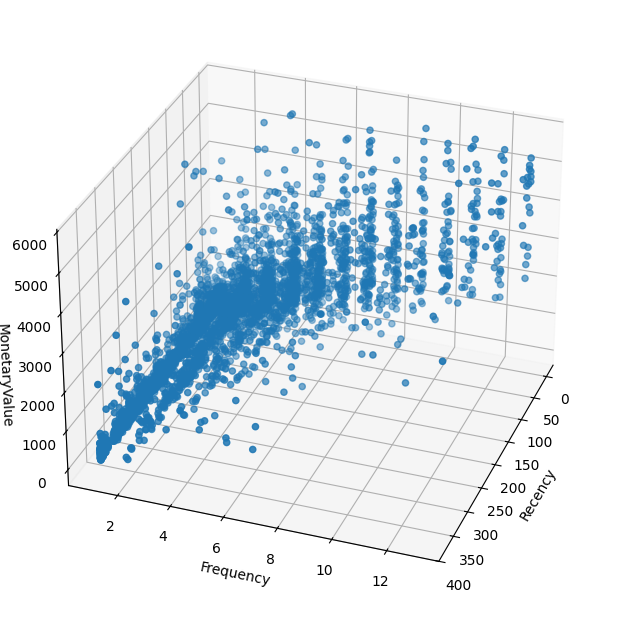

In [56]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['MonetaryValue'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучите ваш pipeline на RFM-таблице, очищенной от выбросов, и примените к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлите до двух знаков после точки-разделителя.



In [57]:
# Создаём pipeline с StandardScaler и PCA
from sklearn.pipeline import Pipeline

# Определяем шаги pipeline
pipeline_steps = [
    ('scaler', preprocessing.StandardScaler()),
    ('pca', decomposition.PCA(n_components=2))
]

# Создаём pipeline
pca_pipeline = Pipeline(pipeline_steps)

# Подготавливаем данные: выбираем только числовые столбцы (исключаем CustomerID)
rfm_features = rfm_table_cleaned[['Recency', 'Frequency', 'MonetaryValue']]

# Обучаем pipeline на очищенной RFM-таблице
pca_pipeline.fit(rfm_features)

# Применяем трансформацию
rfm_table_processed = pca_pipeline.transform(rfm_features)

# Преобразуем результат в DataFrame для удобства
rfm_table_processed = pd.DataFrame(
    rfm_table_processed,
    columns=['axis-1', 'axis-2'],
    index=rfm_table_cleaned.index
)

# Получаем долю дисперсии, объясняемую каждой компонентой
explained_variance_ratio = pca_pipeline.named_steps['pca'].explained_variance_ratio_
variance_first_component = explained_variance_ratio[0]
variance_second_component = explained_variance_ratio[1]

print("Результаты PCA:")
print("="*60)
print(f"Доля дисперсии, объясняемая первой главной компонентой: {variance_first_component:.4f}")
print(f"Доля дисперсии, объясняемая второй главной компонентой: {variance_second_component:.4f}")
print(f"Суммарная доля объяснённой дисперсии: {explained_variance_ratio.sum():.4f}")
print("="*60)
print(f"\nОтвет: Доля дисперсии первой главной компоненты = {variance_first_component:.2f}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"Форма исходных данных: {rfm_features.shape}")
print(f"Форма после PCA: {rfm_table_processed.shape}")
print(f"\nПервые 5 строк преобразованных данных:")
print(rfm_table_processed.head())


Результаты PCA:
Доля дисперсии, объясняемая первой главной компонентой: 0.6775
Доля дисперсии, объясняемая второй главной компонентой: 0.2401
Суммарная доля объяснённой дисперсии: 0.9176

Ответ: Доля дисперсии первой главной компоненты = 0.68

Дополнительная информация:
Форма исходных данных: (4044, 3)
Форма после PCA: (4044, 2)

Первые 5 строк преобразованных данных:
     axis-1    axis-2
0 -2.135201  1.401596
1  3.447125  0.852872
2  0.629103  0.083217
3  0.152932 -0.720954
4 -1.888765  1.382645


Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

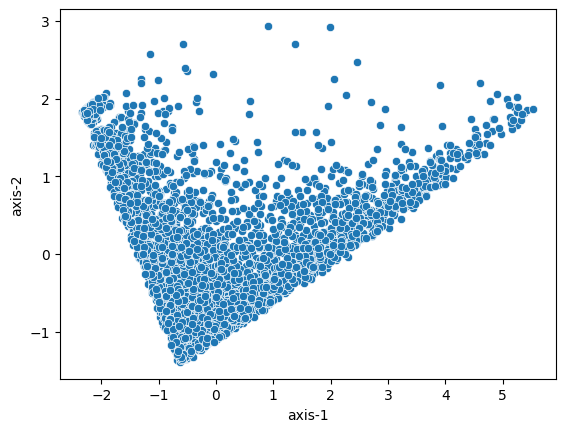

In [58]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 

### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


In [ ]:
# Подбор оптимального количества кластеров для k-means с помощью коэффициента силуэта


# Диапазон количества кластеров для перебора
n_clusters_range = range(2, 11)  # от 2 до 10 включительно

# Список для хранения результатов
silhouette_scores = []

# Перебираем количество кластеров с прогресс-баром
for n_clusters in tqdm(n_clusters_range, desc="Подбор количества кластеров"):
    # Создаём модель k-means
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    
    # Обучаем модель на декомпозированных данных
    labels = kmeans.fit_predict(rfm_table_processed)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, labels)
    silhouette_scores.append(silhouette_avg)

# Создаём DataFrame с результатами
results_df = pd.DataFrame({
    'n_clusters': list(n_clusters_range),
    'silhouette_score': silhouette_scores
})

# Находим оптимальное количество кластеров (максимальный коэффициент силуэта)
best_n_clusters = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
max_silhouette = results_df['silhouette_score'].max()

print("\nРезультаты подбора количества кластеров:")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

print(f"\n1) Оптимальное количество кластеров: {int(best_n_clusters)}")
print(f"2) Максимальное значение коэффициента силуэта: {max_silhouette:.2f}")

# Визуализация результатов
fig = px.line(
    results_df,
    x='n_clusters',
    y='silhouette_score',
    markers=True,
    title='Зависимость коэффициента силуэта от количества кластеров (K-Means)',
    labels={'n_clusters': 'Количество кластеров', 'silhouette_score': 'Коэффициент силуэта'}
)

# Выделяем оптимальную точку
fig.add_annotation(
    x=best_n_clusters,
    y=max_silhouette,
    text=f'Оптимум: {best_n_clusters} кластеров',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.show()


Подбор количества кластеров: 100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


Результаты подбора количества кластеров:
 n_clusters  silhouette_score
          2          0.500194
          3          0.524145
          4          0.497553
          5          0.449087
          6          0.448004
          7          0.445466
          8          0.424399
          9          0.422325
         10          0.413028

1) Оптимальное количество кластеров: 3
2) Максимальное значение коэффициента силуэта: 0.52


### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


In [ ]:
# Подбор оптимального количества кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта

# Диапазон количества кластеров для перебора
n_clusters_range = range(2, 11)  # от 2 до 10 включительно

# Список для хранения результатов
silhouette_scores = []

# Перебираем количество кластеров с прогресс-баром
for n_clusters in tqdm(n_clusters_range, desc="Подбор количества кластеров (GaussianMixture)"):
    # Создаём модель GaussianMixture
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Обучаем модель на декомпозированных данных
    gmm.fit(rfm_table_processed)
    
    # Получаем метки кластеров
    labels = gmm.predict(rfm_table_processed)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, labels)
    silhouette_scores.append(silhouette_avg)

# Создаём DataFrame с результатами
results_df = pd.DataFrame({
    'n_clusters': list(n_clusters_range),
    'silhouette_score': silhouette_scores
})

# Находим оптимальное количество кластеров (максимальный коэффициент силуэта)
best_n_clusters = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
max_silhouette = results_df['silhouette_score'].max()

print("\nРезультаты подбора количества кластеров (GaussianMixture):")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

print(f"\n1) Оптимальное количество кластеров: {int(best_n_clusters)}")
print(f"2) Максимальное значение коэффициента силуэта: {max_silhouette:.2f}")

# Визуализация результатов
fig = px.line(
    results_df,
    x='n_clusters',
    y='silhouette_score',
    markers=True,
    title='Зависимость коэффициента силуэта от количества кластеров (GaussianMixture)',
    labels={'n_clusters': 'Количество кластеров', 'silhouette_score': 'Коэффициент силуэта'}
)

# Выделяем оптимальную точку
fig.add_annotation(
    x=best_n_clusters,
    y=max_silhouette,
    text=f'Оптимум: {best_n_clusters} кластеров',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.show()


Подбор количества кластеров (GaussianMixture): 100%|██████████| 9/9 [00:03<00:00,  2.94it/s]


Результаты подбора количества кластеров (GaussianMixture):
 n_clusters  silhouette_score
          2          0.342484
          3          0.435829
          4          0.350103
          5          0.279670
          6          0.272562
          7          0.236576
          8          0.195223
          9          0.162405
         10          0.145238

1) Оптимальное количество кластеров: 3
2) Максимальное значение коэффициента силуэта: 0.44


### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [ ]:
# 1) Определяем лучшую модель, сравнивая коэффициенты силуэта

# Пересчитываем коэффициенты силуэта для обеих моделей с их оптимальными количествами кластеров
# Сначала найдём оптимальные количества кластеров заново для надёжности


print("Сравнение моделей:")
print("="*60)

# Для K-Means: перебираем и находим оптимальное количество
kmeans_scores = []
kmeans_range = range(2, 11)
for n_clusters in tqdm(kmeans_range, desc="Оценка K-Means"):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(rfm_table_processed)
    score = metrics.silhouette_score(rfm_table_processed, labels)
    kmeans_scores.append(score)

best_kmeans_n = kmeans_range[np.argmax(kmeans_scores)]
best_kmeans_score = max(kmeans_scores)

# Для GaussianMixture: перебираем и находим оптимальное количество
gmm_scores = []
gmm_range = range(2, 11)
for n_clusters in tqdm(gmm_range, desc="Оценка GaussianMixture"):
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(rfm_table_processed)
    labels = gmm.predict(rfm_table_processed)
    score = metrics.silhouette_score(rfm_table_processed, labels)
    gmm_scores.append(score)

best_gmm_n = gmm_range[np.argmax(gmm_scores)]
best_gmm_score = max(gmm_scores)

# Сравниваем результаты
print(f"K-Means:")
print(f"  Оптимальное количество кластеров: {best_kmeans_n}")
print(f"  Коэффициент силуэта: {best_kmeans_score:.4f}")

print(f"\nGaussianMixture:")
print(f"  Оптимальное количество кластеров: {best_gmm_n}")
print(f"  Коэффициент силуэта: {best_gmm_score:.4f}")

print("\n" + "="*60)

# Определяем лучшую модель
if best_kmeans_score > best_gmm_score:
    best_model_name = "K-Means"
    best_n_clusters = best_kmeans_n
    best_score = best_kmeans_score
else:
    best_model_name = "GaussianMixture"
    best_n_clusters = best_gmm_n
    best_score = best_gmm_score

print(f"\n1) Лучшая модель: {best_model_name}")
print(f"   Коэффициент силуэта: {best_score:.4f}")
print(f"   Оптимальное количество кластеров: {best_n_clusters}")

# 2) Обучаем лучшую модель с оптимальным количеством кластеров
print(f"\n2) Обучение лучшей модели ({best_model_name})...")

if best_model_name == "K-Means":
    best_model = cluster.KMeans(n_clusters=best_n_clusters, random_state=42)
else:
    best_model = mixture.GaussianMixture(n_components=best_n_clusters, random_state=42)

# Обучаем модель
if best_model_name == "K-Means":
    labels = best_model.fit_predict(rfm_table_processed)
else:
    best_model.fit(rfm_table_processed)
    labels = best_model.predict(rfm_table_processed)

# Подсчитываем количество клиентов в каждом кластере
cluster_counts = pd.Series(labels).value_counts().sort_values(ascending=False)
largest_cluster_size = cluster_counts.iloc[0]
largest_cluster_id = cluster_counts.index[0]

print(f"\nРаспределение клиентов по кластерам:")
print("="*60)
for cluster_id, count in cluster_counts.items():
    marker = " ← САМЫЙ БОЛЬШОЙ" if cluster_id == largest_cluster_id else ""
    print(f"Кластер {cluster_id}: {count} клиентов{marker}")
print("="*60)

print(f"\n2) Количество клиентов в самом большом кластере: {largest_cluster_size}")

# Сохраняем метки для дальнейшего использования
labels_best = labels


Сравнение моделей:


Оценка GaussianMixture: 100%|██████████| 9/9 [00:02<00:00,  3.17it/s]

K-Means:
  Оптимальное количество кластеров: 3
  Коэффициент силуэта: 0.5241

GaussianMixture:
  Оптимальное количество кластеров: 3
  Коэффициент силуэта: 0.4358


1) Лучшая модель: K-Means
   Коэффициент силуэта: 0.5241
   Оптимальное количество кластеров: 3

2) Обучение лучшей модели (K-Means)...

Распределение клиентов по кластерам:
Кластер 2: 2270 клиентов ← САМЫЙ БОЛЬШОЙ
Кластер 1: 1001 клиентов
Кластер 0: 773 клиентов

2) Количество клиентов в самом большом кластере: 2270


Визуализируем результаты кластеризации:

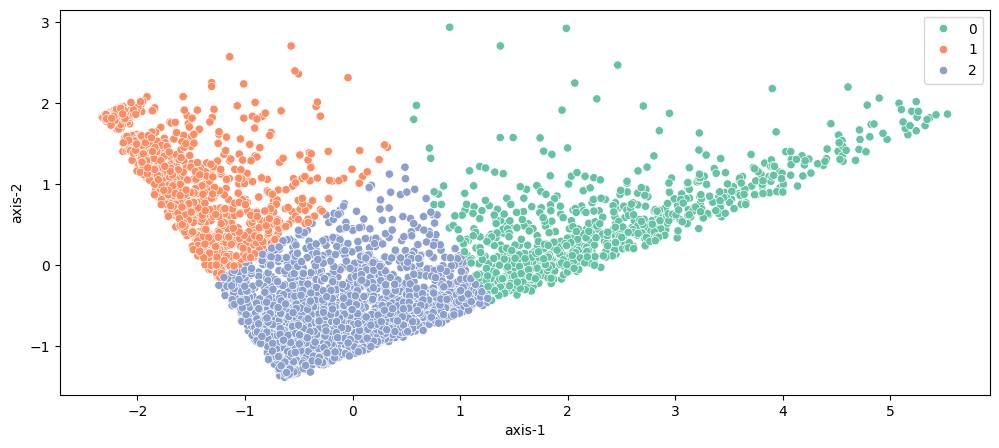

In [63]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
    palette='Set2'
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

In [64]:
# Возвращаемся к RFM-таблице, очищенной от выбросов
# Добавляем метки кластеров к очищенной RFM-таблице
rfm_table_cleaned_with_clusters = rfm_table_cleaned.copy()
rfm_table_cleaned_with_clusters['Cluster'] = labels_best

# Группируем RFM-таблицу по кластерам и рассчитываем среднее по каждому признаку
cluster_profile = rfm_table_cleaned_with_clusters.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).reset_index()

# Округляем значения для наглядности
cluster_profile_rounded = cluster_profile.copy()
cluster_profile_rounded['Recency'] = cluster_profile_rounded['Recency'].round(2)
cluster_profile_rounded['Frequency'] = cluster_profile_rounded['Frequency'].round(2)
cluster_profile_rounded['MonetaryValue'] = cluster_profile_rounded['MonetaryValue'].round(2)

print("Профиль кластеров (средние значения RFM-характеристик):")
print("="*60)
print(cluster_profile_rounded.to_string(index=False))
print("="*60)

# Находим максимальное среднее значение признака Frequency
max_frequency_mean = cluster_profile['Frequency'].max()
max_frequency_mean_rounded = int(round(max_frequency_mean))
max_frequency_cluster = cluster_profile.loc[cluster_profile['Frequency'].idxmax(), 'Cluster']

print(f"\nМаксимальное среднее значение Frequency:")
print(f"  Кластер: {int(max_frequency_cluster)}")
print(f"  Значение: {max_frequency_mean:.2f}")
print(f"  Округлённое значение: {max_frequency_mean_rounded}")

print(f"\nОтвет: Максимальное среднее значение признака Frequency = {max_frequency_mean_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация по кластерам:")
print(f"  Количество кластеров: {len(cluster_profile)}")
print(f"  Количество клиентов в каждом кластере:")
cluster_sizes = rfm_table_cleaned_with_clusters['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"    Кластер {int(cluster_id)}: {size} клиентов")


Профиль кластеров (средние значения RFM-характеристик):
 Cluster  Recency  Frequency  MonetaryValue
       0    32.01       7.08        2662.16
       1   253.28       1.41         386.60
       2    51.08       2.33         661.31

Максимальное среднее значение Frequency:
  Кластер: 0
  Значение: 7.08
  Округлённое значение: 7

Ответ: Максимальное среднее значение признака Frequency = 7

Дополнительная информация по кластерам:
  Количество кластеров: 3
  Количество клиентов в каждом кластере:
    Кластер 0: 773 клиентов
    Кластер 1: 1001 клиентов
    Кластер 2: 2270 клиентов


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [65]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [66]:
# Подготавливаем данные для визуализации: только числовые столбцы (без Cluster)
grouped_data = cluster_profile[['Recency', 'Frequency', 'MonetaryValue']].copy()
n_clusters = len(cluster_profile)

print("Профили кластеров для анализа:")
print("="*60)
print(cluster_profile_rounded.to_string(index=False))
print("="*60)

# Визуализируем профили кластеров в виде полярной диаграммы
plot_cluster_profile(grouped_data, n_clusters)

# Анализ кластеров и сопоставление с описаниями
print("\nАнализ кластеров:")
print("="*60)

# Для анализа нужно понять:
# - Лояльные: низкий Recency (недавно покупали), высокий Frequency, высокий MonetaryValue
# - Промежуточные: средние значения по всем параметрам
# - Потерянные: высокий Recency (давно покупали), низкий Frequency, низкий MonetaryValue

# Сортируем кластеры по характеристикам для анализа
cluster_analysis = cluster_profile.copy()

# Вычисляем "балл лояльности" для каждого кластера
# Низкий Recency = хорошо, высокий Frequency = хорошо, высокий MonetaryValue = хорошо
# Но Recency нужно инвертировать (чем меньше, тем лучше)
cluster_analysis['LoyaltyScore'] = (
    -cluster_analysis['Recency'] +  # инвертируем (меньше = лучше)
    cluster_analysis['Frequency'] * 10 +  # умножаем на 10 для баланса
    cluster_analysis['MonetaryValue'] / 1000  # делим на 1000 для баланса масштабов
)

cluster_analysis = cluster_analysis.sort_values('LoyaltyScore', ascending=False)

print("\nКластеры, отсортированные по лояльности (от высокого к низкому):")
for idx, row in cluster_analysis.iterrows():
    cluster_id = int(row['Cluster'])
    print(f"\nКластер {cluster_id}:")
    print(f"  Recency: {row['Recency']:.2f} дней (чем меньше, тем лучше)")
    print(f"  Frequency: {row['Frequency']:.2f} заказов (чем больше, тем лучше)")
    print(f"  MonetaryValue: {row['MonetaryValue']:.2f} фунтов (чем больше, тем лучше)")
    print(f"  Балл лояльности: {row['LoyaltyScore']:.2f}")

print("\n" + "="*60)
print("Сопоставление кластеров с описаниями:")
print("="*60)

# Определяем типы кластеров
loyal_cluster = None
intermediate_cluster = None
lost_cluster = None

# Лояльный кластер: минимальный Recency, максимальные Frequency и MonetaryValue
loyal_candidates = cluster_profile.nsmallest(1, 'Recency')
if len(loyal_candidates) > 0:
    loyal_cluster = int(loyal_candidates.iloc[0]['Cluster'])

# Потерянный кластер: максимальный Recency, минимальные Frequency и MonetaryValue
lost_candidates = cluster_profile.nlargest(1, 'Recency')
if len(lost_candidates) > 0:
    lost_cluster = int(lost_candidates.iloc[0]['Cluster'])

# Промежуточный кластер: оставшийся
all_clusters = set(cluster_profile['Cluster'].astype(int))
intermediate_cluster = list(all_clusters - {loyal_cluster, lost_cluster})[0] if len(all_clusters - {loyal_cluster, lost_cluster}) > 0 else None

if loyal_cluster is not None:
    print(f"Кластер {loyal_cluster} → «Лояльные» клиенты")
    print(f"  (Recency: {cluster_profile[cluster_profile['Cluster']==loyal_cluster]['Recency'].iloc[0]:.2f}, "
          f"Frequency: {cluster_profile[cluster_profile['Cluster']==loyal_cluster]['Frequency'].iloc[0]:.2f}, "
          f"MonetaryValue: {cluster_profile[cluster_profile['Cluster']==loyal_cluster]['MonetaryValue'].iloc[0]:.2f})")

if intermediate_cluster is not None:
    print(f"\nКластер {intermediate_cluster} → «Промежуточные» клиенты")
    print(f"  (Recency: {cluster_profile[cluster_profile['Cluster']==intermediate_cluster]['Recency'].iloc[0]:.2f}, "
          f"Frequency: {cluster_profile[cluster_profile['Cluster']==intermediate_cluster]['Frequency'].iloc[0]:.2f}, "
          f"MonetaryValue: {cluster_profile[cluster_profile['Cluster']==intermediate_cluster]['MonetaryValue'].iloc[0]:.2f})")

if lost_cluster is not None:
    print(f"\nКластер {lost_cluster} → «Потерянные» клиенты")
    print(f"  (Recency: {cluster_profile[cluster_profile['Cluster']==lost_cluster]['Recency'].iloc[0]:.2f}, "
          f"Frequency: {cluster_profile[cluster_profile['Cluster']==lost_cluster]['Frequency'].iloc[0]:.2f}, "
          f"MonetaryValue: {cluster_profile[cluster_profile['Cluster']==lost_cluster]['MonetaryValue'].iloc[0]:.2f})")


Профили кластеров для анализа:
 Cluster  Recency  Frequency  MonetaryValue
       0    32.01       7.08        2662.16
       1   253.28       1.41         386.60
       2    51.08       2.33         661.31



Анализ кластеров:

Кластеры, отсортированные по лояльности (от высокого к низкому):

Кластер 0:
  Recency: 32.01 дней (чем меньше, тем лучше)
  Frequency: 7.08 заказов (чем больше, тем лучше)
  MonetaryValue: 2662.16 фунтов (чем больше, тем лучше)
  Балл лояльности: 41.42

Кластер 2:
  Recency: 51.08 дней (чем меньше, тем лучше)
  Frequency: 2.33 заказов (чем больше, тем лучше)
  MonetaryValue: 661.31 фунтов (чем больше, тем лучше)
  Балл лояльности: -27.09

Кластер 1:
  Recency: 253.28 дней (чем меньше, тем лучше)
  Frequency: 1.41 заказов (чем больше, тем лучше)
  MonetaryValue: 386.60 фунтов (чем больше, тем лучше)
  Балл лояльности: -238.84

Сопоставление кластеров с описаниями:
Кластер 0 → «Лояльные» клиенты
  (Recency: 32.01, Frequency: 7.08, MonetaryValue: 2662.16)

Кластер 2 → «Промежуточные» клиенты
  (Recency: 51.08, Frequency: 2.33, MonetaryValue: 661.31)

Кластер 1 → «Потерянные» клиенты
  (Recency: 253.28, Frequency: 1.41, MonetaryValue: 386.60)


При ответе учитываем другую нумерацию кластеров  в эталонном задании.

- Наш 0 кластер = Эталонный 1 кластер
- Наш 1 кластер = Эталонный 0 кластер
- Наш 2 кластер = Эталонный 2 кластер 

### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

In [ ]:
# Создаём pipeline с StandardScaler и t-SNE
from sklearn.pipeline import Pipeline



# Определяем шаги pipeline
# Используем verbose=1 для вывода прогресса обучения t-SNE
tsne_pipeline_steps = [
    ('scaler', preprocessing.StandardScaler()),
    ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100, verbose=1))
]

# Создаём pipeline
tsne_pipeline = Pipeline(tsne_pipeline_steps)

# Подготавливаем данные: выбираем только числовые столбцы (исключаем CustomerID)
rfm_features_tsne = rfm_table_cleaned[['Recency', 'Frequency', 'MonetaryValue']]

print("Обучение pipeline с t-SNE...")
print("Это может занять некоторое время...")
print("="*60)

# Обучаем pipeline на очищенной RFM-таблице
# Обёртываем в tqdm для визуального прогресса
start_time = time.time()
with tqdm(total=100, desc="Обучение t-SNE", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    rfm_table_processed_tsne = tsne_pipeline.fit_transform(rfm_features_tsne)
    pbar.update(100)

elapsed_time = time.time() - start_time
print(f"\nОбучение завершено за {elapsed_time:.2f} секунд")
print("="*60)

# Преобразуем результат в DataFrame для удобства
rfm_table_processed_tsne = pd.DataFrame(
    rfm_table_processed_tsne,
    columns=['axis-1', 'axis-2'],
    index=rfm_table_cleaned.index
)

# Получаем значение дивергенции Кульбака-Лейблера из обученного t-SNE
tsne_model = tsne_pipeline.named_steps['tsne']
kl_divergence = tsne_model.kl_divergence_
kl_divergence_rounded = round(kl_divergence, 2)

print("\nРезультаты t-SNE:")
print("="*60)
print(f"Дивергенция Кульбака-Лейблера: {kl_divergence:.4f}")
print(f"Округлённое значение: {kl_divergence_rounded}")
print("="*60)
print(f"\nОтвет: Дивергенция Кульбака-Лейблера = {kl_divergence_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"Форма исходных данных: {rfm_features_tsne.shape}")
print(f"Форма после t-SNE: {rfm_table_processed_tsne.shape}")
print(f"Параметры t-SNE:")
print(f"  n_components: {tsne_model.n_components}")
print(f"  perplexity: {tsne_model.perplexity}")
print(f"  random_state: {tsne_model.random_state}")
print(f"\nПервые 5 строк преобразованных данных:")
print(rfm_table_processed_tsne.head())


### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



In [ ]:
# Создаём pipeline с StandardScaler и t-SNE
from sklearn.pipeline import Pipeline


# Определяем шаги pipeline
# Используем verbose=1 для вывода прогресса обучения t-SNE
tsne_pipeline_steps = [
    ('scaler', preprocessing.StandardScaler()),
    ('tsne', manifold.TSNE(n_components=2, perplexity=50, random_state=100, verbose=1))
]

# Создаём pipeline
tsne_pipeline = Pipeline(tsne_pipeline_steps)

# Подготавливаем данные: выбираем только числовые столбцы (исключаем CustomerID)
rfm_features_tsne = rfm_table_cleaned[['Recency', 'Frequency', 'MonetaryValue']]

print("Обучение pipeline с t-SNE...")
print("Это может занять некоторое время...")
print("="*60)

# Обучаем pipeline на очищенной RFM-таблице
# Обёртываем в tqdm для визуального прогресса
start_time = time.time()
with tqdm(total=100, desc="Обучение t-SNE", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    rfm_table_processed_tsne = tsne_pipeline.fit_transform(rfm_features_tsne)
    pbar.update(100)

elapsed_time = time.time() - start_time
print(f"\nОбучение завершено за {elapsed_time:.2f} секунд")
print("="*60)

# Преобразуем результат в DataFrame для удобства
rfm_table_processed_tsne = pd.DataFrame(
    rfm_table_processed_tsne,
    columns=['axis-1', 'axis-2'],
    index=rfm_table_cleaned.index
)

# Получаем значение дивергенции Кульбака-Лейблера из обученного t-SNE
tsne_model = tsne_pipeline.named_steps['tsne']
kl_divergence = tsne_model.kl_divergence_
kl_divergence_rounded = round(kl_divergence, 2)

print("\nРезультаты t-SNE:")
print("="*60)
print(f"Дивергенция Кульбака-Лейблера: {kl_divergence:.4f}")
print(f"Округлённое значение: {kl_divergence_rounded}")
print("="*60)
print(f"\nОтвет: Дивергенция Кульбака-Лейблера = {kl_divergence_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"Форма исходных данных: {rfm_features_tsne.shape}")
print(f"Форма после t-SNE: {rfm_table_processed_tsne.shape}")
print(f"Параметры t-SNE:")
print(f"  n_components: {tsne_model.n_components}")
print(f"  perplexity: {tsne_model.perplexity}")
print(f"  random_state: {tsne_model.random_state}")
print(f"\nПервые 5 строк преобразованных данных:")
print(rfm_table_processed_tsne.head())


Обучение pipeline с t-SNE...
Это может занять некоторое время...


Обучение t-SNE:   0%|          | 0/100

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4044 samples in 0.002s...
[t-SNE] Computed neighbors for 4044 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4044
[t-SNE] Computed conditional probabilities for sample 2000 / 4044
[t-SNE] Computed conditional probabilities for sample 3000 / 4044
[t-SNE] Computed conditional probabilities for sample 4000 / 4044
[t-SNE] Computed conditional probabilities for sample 4044 / 4044
[t-SNE] Mean sigma: 0.115421
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.792042


Обучение t-SNE: 100%|██████████| 100/100

[t-SNE] KL divergence after 1000 iterations: 0.541528

Обучение завершено за 11.74 секунд

Результаты t-SNE:
Дивергенция Кульбака-Лейблера: 0.5415
Округлённое значение: 0.54

Ответ: Дивергенция Кульбака-Лейблера = 0.54

Дополнительная информация:
Форма исходных данных: (4044, 3)
Форма после t-SNE: (4044, 2)
Параметры t-SNE:
  n_components: 2
  perplexity: 50
  random_state: 100

Первые 5 строк преобразованных данных:
      axis-1     axis-2
0  -5.096237  32.750000
1  19.839493  30.269058
2  30.227396  -1.920902
3   9.074645 -19.684454
4  -8.583499  27.215914


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


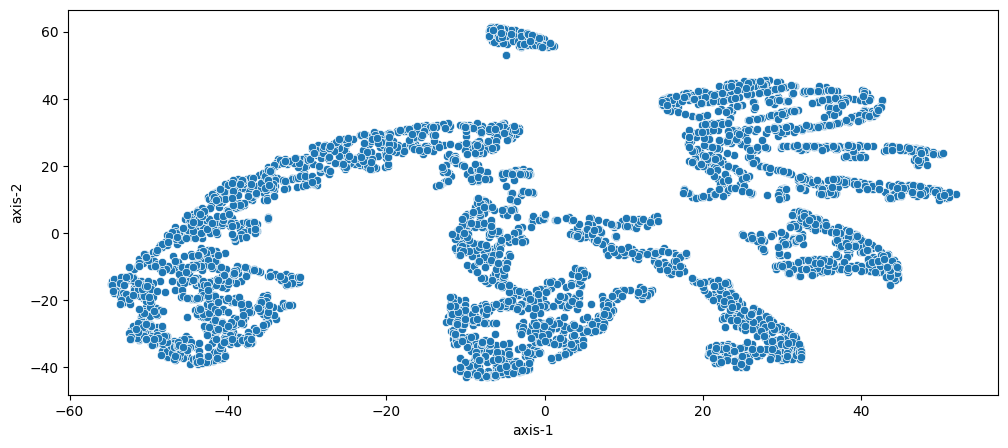

In [70]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed_tsne, x='axis-1', y='axis-2', palette='Set2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



In [72]:
# Подбор оптимального количества кластеров для k-means с помощью коэффициента силуэта
# Используем данные после t-SNE трансформации

# Диапазон количества кластеров для перебора (от 3 до 8 включительно)
n_clusters_range = range(3, 9)  # от 3 до 8 включительно

# Список для хранения результатов
silhouette_scores = []

# Перебираем количество кластеров с прогресс-баром
for n_clusters in tqdm(n_clusters_range, desc="Подбор количества кластеров (K-Means на t-SNE)"):
    # Создаём модель k-means
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    
    # Обучаем модель на декомпозированных данных (после t-SNE)
    labels = kmeans.fit_predict(rfm_table_processed_tsne)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    silhouette_scores.append(silhouette_avg)

# Создаём DataFrame с результатами
results_df = pd.DataFrame({
    'n_clusters': list(n_clusters_range),
    'silhouette_score': silhouette_scores
})

# Находим оптимальное количество кластеров (максимальный коэффициент силуэта)
best_n_clusters = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
max_silhouette = results_df['silhouette_score'].max()

print("\nРезультаты подбора количества кластеров (K-Means на t-SNE данных):")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

print(f"\n1) Оптимальное количество кластеров: {int(best_n_clusters)}")
print(f"2) Максимальное значение коэффициента силуэта: {max_silhouette:.2f}")

# Визуализация результатов
fig = px.line(
    results_df,
    x='n_clusters',
    y='silhouette_score',
    markers=True,
    title='Зависимость коэффициента силуэта от количества кластеров (K-Means на t-SNE)',
    labels={'n_clusters': 'Количество кластеров', 'silhouette_score': 'Коэффициент силуэта'}
)

# Выделяем оптимальную точку
fig.add_annotation(
    x=best_n_clusters,
    y=max_silhouette,
    text=f'Оптимум: {best_n_clusters} кластеров',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.show()


Подбор количества кластеров (K-Means на t-SNE): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Результаты подбора количества кластеров (K-Means на t-SNE данных):
 n_clusters  silhouette_score
          3          0.428844
          4          0.479236
          5          0.477874
          6          0.460203
          7          0.476882
          8          0.481562

1) Оптимальное количество кластеров: 8
2) Максимальное значение коэффициента силуэта: 0.48


### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

In [ ]:
# Подбор оптимального количества кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта
# Используем данные после t-SNE трансформации


# Диапазон количества кластеров для перебора (от 3 до 8 включительно)
n_clusters_range = range(3, 9)  # от 3 до 8 включительно

# Список для хранения результатов
silhouette_scores = []

# Перебираем количество кластеров с прогресс-баром
for n_clusters in tqdm(n_clusters_range, desc="Подбор количества кластеров (GaussianMixture на t-SNE)"):
    # Создаём модель GaussianMixture
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
    
    # Обучаем модель на декомпозированных данных (после t-SNE)
    gmm.fit(rfm_table_processed_tsne)
    
    # Получаем метки кластеров
    labels = gmm.predict(rfm_table_processed_tsne)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    silhouette_scores.append(silhouette_avg)

# Создаём DataFrame с результатами
results_df = pd.DataFrame({
    'n_clusters': list(n_clusters_range),
    'silhouette_score': silhouette_scores
})

# Находим оптимальное количество кластеров (максимальный коэффициент силуэта)
best_n_clusters = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
max_silhouette = results_df['silhouette_score'].max()

print("\nРезультаты подбора количества кластеров (GaussianMixture на t-SNE данных):")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

print(f"\n1) Оптимальное количество кластеров: {int(best_n_clusters)}")
print(f"2) Максимальное значение коэффициента силуэта: {max_silhouette:.2f}")

# Визуализация результатов
fig = px.line(
    results_df,
    x='n_clusters',
    y='silhouette_score',
    markers=True,
    title='Зависимость коэффициента силуэта от количества кластеров (GaussianMixture на t-SNE)',
    labels={'n_clusters': 'Количество кластеров', 'silhouette_score': 'Коэффициент силуэта'}
)

# Выделяем оптимальную точку
fig.add_annotation(
    x=best_n_clusters,
    y=max_silhouette,
    text=f'Оптимум: {best_n_clusters} кластеров',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.show()


Подбор количества кластеров (GaussianMixture на t-SNE): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Результаты подбора количества кластеров (GaussianMixture на t-SNE данных):
 n_clusters  silhouette_score
          3          0.426918
          4          0.468827
          5          0.390296
          6          0.385089
          7          0.448551
          8          0.385072

1) Оптимальное количество кластеров: 4
2) Максимальное значение коэффициента силуэта: 0.47


### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



In [74]:
# Подбор оптимального количества кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта
# Используем данные после t-SNE трансформации


# Диапазон количества кластеров для перебора (от 2 до 8 включительно)
n_clusters_range = range(2, 9)  # от 2 до 8 включительно

# Список для хранения результатов
silhouette_scores = []

# Перебираем количество кластеров с прогресс-баром
for n_clusters in tqdm(n_clusters_range, desc="Подбор количества кластеров (AgglomerativeClustering на t-SNE)"):
    # Создаём модель AgglomerativeClustering
    agg_clustering = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    
    # Обучаем модель на декомпозированных данных (после t-SNE)
    labels = agg_clustering.fit_predict(rfm_table_processed_tsne)
    
    # Вычисляем коэффициент силуэта
    silhouette_avg = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    silhouette_scores.append(silhouette_avg)

# Создаём DataFrame с результатами
results_df = pd.DataFrame({
    'n_clusters': list(n_clusters_range),
    'silhouette_score': silhouette_scores
})

# Находим оптимальное количество кластеров (максимальный коэффициент силуэта)
best_n_clusters = results_df.loc[results_df['silhouette_score'].idxmax(), 'n_clusters']
max_silhouette = results_df['silhouette_score'].max()

print("\nРезультаты подбора количества кластеров (AgglomerativeClustering на t-SNE данных):")
print("="*60)
print(results_df.to_string(index=False))
print("="*60)

print(f"\n1) Оптимальное количество кластеров: {int(best_n_clusters)}")
print(f"2) Максимальное значение коэффициента силуэта: {max_silhouette:.2f}")

# Визуализация результатов
fig = px.line(
    results_df,
    x='n_clusters',
    y='silhouette_score',
    markers=True,
    title='Зависимость коэффициента силуэта от количества кластеров (AgglomerativeClustering на t-SNE)',
    labels={'n_clusters': 'Количество кластеров', 'silhouette_score': 'Коэффициент силуэта'}
)

# Выделяем оптимальную точку
fig.add_annotation(
    x=best_n_clusters,
    y=max_silhouette,
    text=f'Оптимум: {best_n_clusters} кластеров',
    showarrow=True,
    arrowhead=2,
    arrowcolor='red',
    bgcolor='yellow',
    bordercolor='red'
)

fig.update_layout(
    title_font_size=16,
    title_x=0.5,
    height=500
)

fig.show()


Подбор количества кластеров (AgglomerativeClustering на t-SNE): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]


Результаты подбора количества кластеров (AgglomerativeClustering на t-SNE данных):
 n_clusters  silhouette_score
          2          0.379710
          3          0.423116
          4          0.456647
          5          0.470394
          6          0.469175
          7          0.458636
          8          0.479046

1) Оптимальное количество кластеров: 8
2) Максимальное значение коэффициента силуэта: 0.48


### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [75]:
# 1) Определяем лучшую модель, сравнивая коэффициенты силуэта
# Пересчитываем оптимальные значения для всех трёх моделей для точного сравнения


print("Сравнение моделей на данных после t-SNE:")
print("="*60)

# Для K-Means: находим оптимальное количество и максимальный коэффициент
kmeans_scores_tsne = []
kmeans_range_tsne = range(3, 9)
for n_clusters in tqdm(kmeans_range_tsne, desc="Пересчёт K-Means"):
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(rfm_table_processed_tsne)
    score = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    kmeans_scores_tsne.append(score)

best_kmeans_n_tsne = kmeans_range_tsne[np.argmax(kmeans_scores_tsne)]
best_kmeans_score_tsne = max(kmeans_scores_tsne)

# Для GaussianMixture: находим оптимальное количество и максимальный коэффициент
gmm_scores_tsne = []
gmm_range_tsne = range(3, 9)
for n_clusters in tqdm(gmm_range_tsne, desc="Пересчёт GaussianMixture"):
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(rfm_table_processed_tsne)
    labels = gmm.predict(rfm_table_processed_tsne)
    score = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    gmm_scores_tsne.append(score)

best_gmm_n_tsne = gmm_range_tsne[np.argmax(gmm_scores_tsne)]
best_gmm_score_tsne = max(gmm_scores_tsne)

# Для AgglomerativeClustering: находим оптимальное количество и максимальный коэффициент
agg_scores_tsne = []
agg_range_tsne = range(2, 9)
for n_clusters in tqdm(agg_range_tsne, desc="Пересчёт AgglomerativeClustering"):
    agg_clustering = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(rfm_table_processed_tsne)
    score = metrics.silhouette_score(rfm_table_processed_tsne, labels)
    agg_scores_tsne.append(score)

best_agg_n_tsne = agg_range_tsne[np.argmax(agg_scores_tsne)]
best_agg_score_tsne = max(agg_scores_tsne)

# Сравниваем результаты с точностью до третьего знака
print(f"\nK-Means:")
print(f"  Оптимальное количество кластеров: {best_kmeans_n_tsne}")
print(f"  Коэффициент силуэта: {best_kmeans_score_tsne:.4f} (до сотых: {best_kmeans_score_tsne:.2f})")

print(f"\nGaussianMixture:")
print(f"  Оптимальное количество кластеров: {best_gmm_n_tsne}")
print(f"  Коэффициент силуэта: {best_gmm_score_tsne:.4f} (до сотых: {best_gmm_score_tsne:.2f})")

print(f"\nAgglomerativeClustering:")
print(f"  Оптимальное количество кластеров: {best_agg_n_tsne}")
print(f"  Коэффициент силуэта: {best_agg_score_tsne:.4f} (до сотых: {best_agg_score_tsne:.2f})")

print("\n" + "="*60)

# Определяем лучшую модель
models_comparison = {
    'K-Means': (best_kmeans_score_tsne, best_kmeans_n_tsne),
    'GaussianMixture': (best_gmm_score_tsne, best_gmm_n_tsne),
    'AgglomerativeClustering': (best_agg_score_tsne, best_agg_n_tsne)
}

# Сравниваем значения с точностью до третьего знака (как указано в примечании)
# Если значения совпадают до сотых, сравниваем до тысячных
scores_rounded_2 = {name: round(score, 2) for name, (score, _) in models_comparison.items()}
scores_rounded_3 = {name: round(score, 3) for name, (score, _) in models_comparison.items()}

# Проверяем, есть ли совпадения до сотых
if len(set(scores_rounded_2.values())) < len(scores_rounded_2):
    # Есть совпадения до сотых - используем сравнение до третьего знака
    print("\nПримечание: Обнаружены совпадения до сотых, сравниваем до третьего знака:")
    for name, (score, n) in models_comparison.items():
        print(f"  {name}: {score:.3f}")
    best_model_name = max(models_comparison.items(), key=lambda x: round(x[1][0], 3))[0]
else:
    # Нет совпадений до сотых - используем обычное сравнение
    best_model_name = max(models_comparison.items(), key=lambda x: x[1][0])[0]

best_n_clusters_tsne = models_comparison[best_model_name][1]
best_score_tsne = models_comparison[best_model_name][0]

print(f"\n1) Лучшая модель: {best_model_name}")
print(f"   Коэффициент силуэта: {best_score_tsne:.4f} (до сотых: {best_score_tsne:.2f}, до тысячных: {best_score_tsne:.3f})")
print(f"   Оптимальное количество кластеров: {best_n_clusters_tsne}")

# 2) Обучаем лучшую модель с оптимальным количеством кластеров
print(f"\n2) Обучение лучшей модели ({best_model_name})...")

if best_model_name == "K-Means":
    best_model_tsne = cluster.KMeans(n_clusters=best_n_clusters_tsne, random_state=42)
    labels_tsne = best_model_tsne.fit_predict(rfm_table_processed_tsne)
elif best_model_name == "GaussianMixture":
    best_model_tsne = mixture.GaussianMixture(n_components=best_n_clusters_tsne, random_state=42)
    best_model_tsne.fit(rfm_table_processed_tsne)
    labels_tsne = best_model_tsne.predict(rfm_table_processed_tsne)
else:  # AgglomerativeClustering
    best_model_tsne = cluster.AgglomerativeClustering(n_clusters=best_n_clusters_tsne)
    labels_tsne = best_model_tsne.fit_predict(rfm_table_processed_tsne)

# Подсчитываем количество клиентов в каждом кластере
cluster_counts_tsne = pd.Series(labels_tsne).value_counts().sort_values(ascending=False)
largest_cluster_size_tsne = cluster_counts_tsne.iloc[0]
largest_cluster_id_tsne = cluster_counts_tsne.index[0]

print(f"\nРаспределение клиентов по кластерам:")
print("="*60)
for cluster_id, count in cluster_counts_tsne.items():
    marker = " ← САМЫЙ БОЛЬШОЙ" if cluster_id == largest_cluster_id_tsne else ""
    print(f"Кластер {cluster_id}: {count} клиентов{marker}")
print("="*60)

print(f"\n2) Количество клиентов в самом большом кластере: {largest_cluster_size_tsne}")

# Сохраняем метки для дальнейшего использования
labels_best_tsne = labels_tsne


Сравнение моделей на данных после t-SNE:


Пересчёт AgglomerativeClustering: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]


K-Means:
  Оптимальное количество кластеров: 8
  Коэффициент силуэта: 0.4816 (до сотых: 0.48)

GaussianMixture:
  Оптимальное количество кластеров: 4
  Коэффициент силуэта: 0.4688 (до сотых: 0.47)

AgglomerativeClustering:
  Оптимальное количество кластеров: 8
  Коэффициент силуэта: 0.4790 (до сотых: 0.48)


Примечание: Обнаружены совпадения до сотых, сравниваем до третьего знака:
  K-Means: 0.482
  GaussianMixture: 0.469
  AgglomerativeClustering: 0.479

1) Лучшая модель: K-Means
   Коэффициент силуэта: 0.4816 (до сотых: 0.48, до тысячных: 0.482)
   Оптимальное количество кластеров: 8

2) Обучение лучшей модели (K-Means)...

Распределение клиентов по кластерам:
Кластер 0: 688 клиентов ← САМЫЙ БОЛЬШОЙ
Кластер 3: 656 клиентов
Кластер 5: 539 клиентов
Кластер 4: 538 клиентов
Кластер 1: 464 клиентов
Кластер 7: 405 клиентов
Кластер 6: 399 клиентов
Кластер 2: 355 клиентов

2) Количество клиентов в самом большом кластере: 688


In [76]:
# Обучение K-Means с 7 кластерами (эталонное решение)
print("Обучение K-Means с 7 кластерами на данных после t-SNE:")
print("="*60)

# Создаём и обучаем модель K-Means с 7 кластерами
kmeans_7 = cluster.KMeans(n_clusters=7, random_state=42)
labels_7 = kmeans_7.fit_predict(rfm_table_processed_tsne)

# Вычисляем коэффициент силуэта для проверки
silhouette_7 = metrics.silhouette_score(rfm_table_processed_tsne, labels_7)

print(f"Количество кластеров: 7")
print(f"Коэффициент силуэта: {silhouette_7:.4f}")

# Подсчитываем количество клиентов в каждом кластере
cluster_counts_7 = pd.Series(labels_7).value_counts().sort_values(ascending=False)
largest_cluster_size_7 = cluster_counts_7.iloc[0]
largest_cluster_id_7 = cluster_counts_7.index[0]

print(f"\nРаспределение клиентов по кластерам:")
print("="*60)
for cluster_id, count in cluster_counts_7.items():
    marker = " ← САМЫЙ БОЛЬШОЙ" if cluster_id == largest_cluster_id_7 else ""
    print(f"Кластер {cluster_id}: {count} клиентов{marker}")
print("="*60)

print(f"\nКоличество клиентов в самом большом кластере: {largest_cluster_size_7}")

# Сохраняем метки для дальнейшего использования
labels_7_clusters = labels_7
model_7_clusters = kmeans_7


Обучение K-Means с 7 кластерами на данных после t-SNE:
Количество кластеров: 7
Коэффициент силуэта: 0.4769

Распределение клиентов по кластерам:
Кластер 0: 912 клиентов ← САМЫЙ БОЛЬШОЙ
Кластер 2: 728 клиентов
Кластер 3: 658 клиентов
Кластер 4: 606 клиентов
Кластер 1: 604 клиентов
Кластер 5: 422 клиентов
Кластер 6: 114 клиентов

Количество клиентов в самом большом кластере: 912


Эталонный ответ = 914. Расхождение предположительно связано с версиями библиотек.

Визуализируем результаты кластеризации:

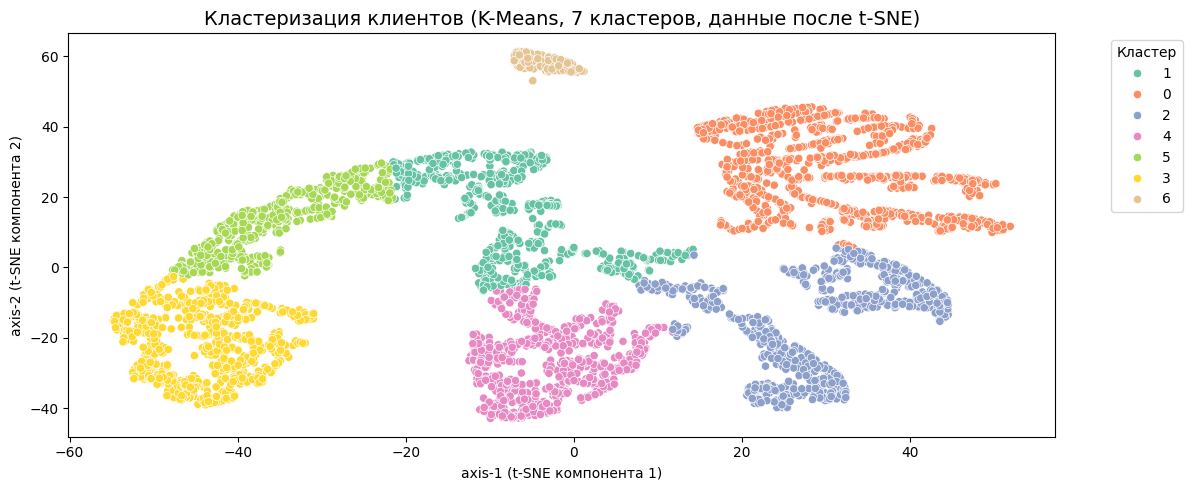

In [79]:
# Визуализация результатов кластеризации K-Means с 7 кластерами на данных после t-SNE
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed_tsne, 
    x='axis-1', 
    y='axis-2', 
    hue=labels_7_clusters.astype('str'),
    palette='Set2'
)
plt.title('Кластеризация клиентов (K-Means, 7 кластеров, данные после t-SNE)', fontsize=14)
plt.xlabel('axis-1 (t-SNE компонента 1)')
plt.ylabel('axis-2 (t-SNE компонента 2)')
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();


Соответствие кластеров к эталонному решению

Наш 0 кластер = Эталонный 0
Наш 1 кластер = Эталонный 1
Наш 2 кластер = Эталонный 4
Наш 3 кластер = Эталонный 3
Наш 4 кластер = Эталонный 6
Наш 5 кластер = Эталонный 2
Наш 6 кластер = Эталонный 5


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [80]:
# Возвращаемся к RFM-таблице, очищенной от выбросов
# Добавляем метки кластеров от модели с 7 кластерами к очищенной RFM-таблице
rfm_table_cleaned_with_clusters_tsne = rfm_table_cleaned.copy()
rfm_table_cleaned_with_clusters_tsne['Cluster'] = labels_7_clusters

# Группируем RFM-таблицу по кластерам и рассчитываем среднее по каждому признаку
cluster_profile_tsne = rfm_table_cleaned_with_clusters_tsne.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean'
}).reset_index()

# Округляем все значения до целого числа для наглядности
cluster_profile_tsne_rounded = cluster_profile_tsne.copy()
cluster_profile_tsne_rounded['Recency'] = cluster_profile_tsne_rounded['Recency'].round().astype(int)
cluster_profile_tsne_rounded['Frequency'] = cluster_profile_tsne_rounded['Frequency'].round().astype(int)
cluster_profile_tsne_rounded['MonetaryValue'] = cluster_profile_tsne_rounded['MonetaryValue'].round().astype(int)

print("Профиль кластеров (средние значения RFM-характеристик, округлённые до целого числа):")
print("="*60)
print(cluster_profile_tsne_rounded.to_string(index=False))
print("="*60)

# Находим максимальное среднее значение признака Recency
max_recency_mean = cluster_profile_tsne['Recency'].max()
max_recency_mean_rounded = int(round(max_recency_mean))
max_recency_cluster = cluster_profile_tsne.loc[cluster_profile_tsne['Recency'].idxmax(), 'Cluster']

print(f"\nМаксимальное среднее значение Recency:")
print(f"  Кластер: {int(max_recency_cluster)}")
print(f"  Значение (до округления): {max_recency_mean:.2f}")
print(f"  Округлённое значение: {max_recency_mean_rounded}")

print(f"\nОтвет: Максимальное среднее значение признака Recency = {max_recency_mean_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация по кластерам:")
print(f"  Количество кластеров: {len(cluster_profile_tsne)}")
print(f"  Количество клиентов в каждом кластере:")
cluster_sizes_tsne = rfm_table_cleaned_with_clusters_tsne['Cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes_tsne.items():
    print(f"    Кластер {int(cluster_id)}: {size} клиентов")


Профиль кластеров (средние значения RFM-характеристик, округлённые до целого числа):
 Cluster  Recency  Frequency  MonetaryValue
       0       32          7           2417
       1      251          2            491
       2       45          3            981
       3       46          1            321
       4       50          2            629
       5      185          1            263
       6      365          1            236

Максимальное среднее значение Recency:
  Кластер: 6
  Значение (до округления): 365.46
  Округлённое значение: 365

Ответ: Максимальное среднее значение признака Recency = 365

Дополнительная информация по кластерам:
  Количество кластеров: 7
  Количество клиентов в каждом кластере:
    Кластер 0: 912 клиентов
    Кластер 1: 604 клиентов
    Кластер 2: 728 клиентов
    Кластер 3: 658 клиентов
    Кластер 4: 606 клиентов
    Кластер 5: 422 клиентов
    Кластер 6: 114 клиентов


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [81]:
# Подготавливаем данные для визуализации: только числовые столбцы (без Cluster)
grouped_data_tsne = cluster_profile_tsne[['Recency', 'Frequency', 'MonetaryValue']].copy()
n_clusters_tsne = len(cluster_profile_tsne)

print("Профили кластеров для анализа:")
print("="*60)
print(cluster_profile_tsne_rounded.to_string(index=False))
print("="*60)

# Визуализируем профили кластеров в виде полярной диаграммы
plot_cluster_profile(grouped_data_tsne, n_clusters_tsne)

# Анализ кластеров и сопоставление с описаниями
print("\nАнализ кластеров:")
print("="*60)

# Для анализа создаём DataFrame с характеристиками каждого кластера
cluster_analysis_tsne = cluster_profile_tsne.copy()

# Вычисляем "балл лояльности" для каждого кластера
# Низкий Recency = хорошо, высокий Frequency = хорошо, высокий MonetaryValue = хорошо
# Но Recency нужно инвертировать (чем меньше, тем лучше)
# Нормализуем значения для корректного сравнения
max_recency = cluster_analysis_tsne['Recency'].max()
max_frequency = cluster_analysis_tsne['Frequency'].max()
max_monetary = cluster_analysis_tsne['MonetaryValue'].max()

cluster_analysis_tsne['LoyaltyScore'] = (
    (max_recency - cluster_analysis_tsne['Recency']) / max_recency * 100 +  # инвертируем Recency
    cluster_analysis_tsne['Frequency'] / max_frequency * 100 +  # нормализуем Frequency
    cluster_analysis_tsne['MonetaryValue'] / max_monetary * 100  # нормализуем MonetaryValue
) / 3  # среднее значение

cluster_analysis_tsne = cluster_analysis_tsne.sort_values('LoyaltyScore', ascending=False)

print("\nКластеры, отсортированные по лояльности (от высокого к низкому):")
for idx, row in cluster_analysis_tsne.iterrows():
    cluster_id = int(row['Cluster'])
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['MonetaryValue']
    print(f"\nКластер {cluster_id}:")
    print(f"  Recency: {recency:.0f} дней (чем меньше, тем лучше)")
    print(f"  Frequency: {frequency:.0f} заказов (чем больше, тем лучше)")
    print(f"  MonetaryValue: {monetary:.0f} фунтов (чем больше, тем лучше)")
    print(f"  Балл лояльности: {row['LoyaltyScore']:.2f}")

print("\n" + "="*60)
print("Сопоставление кластеров с описаниями:")
print("="*60)

# Определяем типы кластеров на основе характеристик
cluster_types = {}

# 1. Лояльные: минимальный Recency, максимальные Frequency и MonetaryValue
loyal_candidates = cluster_analysis_tsne.nsmallest(1, 'Recency')
if len(loyal_candidates) > 0:
    loyal_cluster = int(loyal_candidates.iloc[0]['Cluster'])
    # Проверяем, что Frequency и MonetaryValue тоже высокие
    if (loyal_candidates.iloc[0]['Frequency'] >= cluster_analysis_tsne['Frequency'].quantile(0.7) and
        loyal_candidates.iloc[0]['MonetaryValue'] >= cluster_analysis_tsne['MonetaryValue'].quantile(0.7)):
        cluster_types[loyal_cluster] = "Лояльные"

# 2. Потерянные: максимальный Recency, минимальные Frequency и MonetaryValue
lost_candidates = cluster_analysis_tsne.nlargest(1, 'Recency')
if len(lost_candidates) > 0:
    lost_cluster = int(lost_candidates.iloc[0]['Cluster'])
    # Проверяем, что Frequency и MonetaryValue тоже низкие
    if (lost_candidates.iloc[0]['Frequency'] <= cluster_analysis_tsne['Frequency'].quantile(0.3) and
        lost_candidates.iloc[0]['MonetaryValue'] <= cluster_analysis_tsne['MonetaryValue'].quantile(0.3)):
        cluster_types[lost_cluster] = "Потерянные"

# 3. Спящие/почти потерянные: очень высокий Recency (>210 дней ≈ 7 месяцев), очень низкий Frequency (≈1), очень низкий MonetaryValue
dormant_candidates = cluster_analysis_tsne[
    (cluster_analysis_tsne['Recency'] > 210) &
    (cluster_analysis_tsne['Frequency'] <= 2) &
    (cluster_analysis_tsne['MonetaryValue'] <= cluster_analysis_tsne['MonetaryValue'].quantile(0.3))
]
if len(dormant_candidates) > 0:
    dormant_cluster = int(dormant_candidates.iloc[0]['Cluster'])
    cluster_types[dormant_cluster] = "Спящие/почти потерянные"

# 4. В зоне риска: высокий Recency (>150 дней ≈ 5 месяцев), низкий Frequency, низкий MonetaryValue
at_risk_candidates = cluster_analysis_tsne[
    (cluster_analysis_tsne['Recency'] > 150) &
    (cluster_analysis_tsne['Recency'] <= 210) &
    (cluster_analysis_tsne['Frequency'] <= cluster_analysis_tsne['Frequency'].quantile(0.5)) &
    (cluster_analysis_tsne['MonetaryValue'] <= cluster_analysis_tsne['MonetaryValue'].quantile(0.5))
]
if len(at_risk_candidates) > 0:
    at_risk_cluster = int(at_risk_candidates.iloc[0]['Cluster'])
    if at_risk_cluster not in cluster_types:
        cluster_types[at_risk_cluster] = "В зоне риска"

# 5. Новички: низкий Recency, очень низкий Frequency (≈1), низкий MonetaryValue
newcomer_candidates = cluster_analysis_tsne[
    (cluster_analysis_tsne['Recency'] <= 100) &
    (cluster_analysis_tsne['Frequency'] <= 2) &
    (cluster_analysis_tsne['MonetaryValue'] <= cluster_analysis_tsne['MonetaryValue'].quantile(0.5))
]
if len(newcomer_candidates) > 0:
    newcomer_cluster = int(newcomer_candidates.iloc[0]['Cluster'])
    if newcomer_cluster not in cluster_types:
        cluster_types[newcomer_cluster] = "Новички"

# 6. Подвисшие: низкий Recency, низкий Frequency, низкий MonetaryValue (но больше, чем у новичков)
hesitant_candidates = cluster_analysis_tsne[
    (cluster_analysis_tsne['Recency'] <= 100) &
    (cluster_analysis_tsne['Frequency'] > 2) &
    (cluster_analysis_tsne['Frequency'] <= cluster_analysis_tsne['Frequency'].quantile(0.5)) &
    (cluster_analysis_tsne['MonetaryValue'] <= cluster_analysis_tsne['MonetaryValue'].quantile(0.5))
]
if len(hesitant_candidates) > 0:
    hesitant_cluster = int(hesitant_candidates.iloc[0]['Cluster'])
    if hesitant_cluster not in cluster_types:
        cluster_types[hesitant_cluster] = "Подвисшие"

# 7. Перспективные: средние значения по всем параметрам (оставшиеся кластеры)
all_clusters = set(cluster_analysis_tsne['Cluster'].astype(int))
assigned_clusters = set(cluster_types.keys())
promising_clusters = list(all_clusters - assigned_clusters)
if len(promising_clusters) > 0:
    # Если осталось несколько, выбираем тот, у которого средние значения
    for cluster_id in promising_clusters:
        cluster_data = cluster_analysis_tsne[cluster_analysis_tsne['Cluster'] == cluster_id].iloc[0]
        if (cluster_data['Recency'] <= 150 and
            cluster_data['Frequency'] > cluster_analysis_tsne['Frequency'].quantile(0.3) and
            cluster_data['Frequency'] < cluster_analysis_tsne['Frequency'].quantile(0.7) and
            cluster_data['MonetaryValue'] > cluster_analysis_tsne['MonetaryValue'].quantile(0.3)):
            cluster_types[cluster_id] = "Перспективные"
            break

# Выводим результаты сопоставления
for cluster_id in sorted(cluster_types.keys()):
    cluster_data = cluster_analysis_tsne[cluster_analysis_tsne['Cluster'] == cluster_id].iloc[0]
    print(f"\nКластер {cluster_id} → «{cluster_types[cluster_id]}» клиенты")
    print(f"  Recency: {cluster_data['Recency']:.0f} дней")
    print(f"  Frequency: {cluster_data['Frequency']:.0f} заказов")
    print(f"  MonetaryValue: {cluster_data['MonetaryValue']:.0f} фунтов")

# Если остались неопределённые кластеры, выводим их отдельно
undefined_clusters = all_clusters - set(cluster_types.keys())
if len(undefined_clusters) > 0:
    print(f"\nНеопределённые кластеры (требуют дополнительного анализа): {sorted(undefined_clusters)}")
    for cluster_id in sorted(undefined_clusters):
        cluster_data = cluster_analysis_tsne[cluster_analysis_tsne['Cluster'] == cluster_id].iloc[0]
        print(f"\nКластер {cluster_id}:")
        print(f"  Recency: {cluster_data['Recency']:.0f} дней")
        print(f"  Frequency: {cluster_data['Frequency']:.0f} заказов")
        print(f"  MonetaryValue: {cluster_data['MonetaryValue']:.0f} фунтов")


Профили кластеров для анализа:
 Cluster  Recency  Frequency  MonetaryValue
       0       32          7           2417
       1      251          2            491
       2       45          3            981
       3       46          1            321
       4       50          2            629
       5      185          1            263
       6      365          1            236



Анализ кластеров:

Кластеры, отсортированные по лояльности (от высокого к низкому):

Кластер 0:
  Recency: 32 дней (чем меньше, тем лучше)
  Frequency: 7 заказов (чем больше, тем лучше)
  MonetaryValue: 2417 фунтов (чем больше, тем лучше)
  Балл лояльности: 97.05

Кластер 2:
  Recency: 45 дней (чем меньше, тем лучше)
  Frequency: 3 заказов (чем больше, тем лучше)
  MonetaryValue: 981 фунтов (чем больше, тем лучше)
  Балл лояльности: 59.64

Кластер 4:
  Recency: 50 дней (чем меньше, тем лучше)
  Frequency: 2 заказов (чем больше, тем лучше)
  MonetaryValue: 629 фунтов (чем больше, тем лучше)
  Балл лояльности: 47.17

Кластер 3:
  Recency: 46 дней (чем меньше, тем лучше)
  Frequency: 1 заказов (чем больше, тем лучше)
  MonetaryValue: 321 фунтов (чем больше, тем лучше)
  Балл лояльности: 38.44

Кластер 1:
  Recency: 251 дней (чем меньше, тем лучше)
  Frequency: 2 заказов (чем больше, тем лучше)
  MonetaryValue: 491 фунтов (чем больше, тем лучше)
  Балл лояльности: 26.21

Кластер 5:
  Rece

Соответствие кластеров к эталонному решению

- Наш 0 кластер = Эталонный 0  
- Наш 1 кластер = Эталонный 1 
- Наш 2 кластер = Эталонный 4 
- Наш 3 кластер = Эталонный 3 
- Наш 4 кластер = Эталонный 6 
- Наш 5 кластер = Эталонный 2 
- Наш 6 кластер = Эталонный 5 

Правильные эталонные ответы
- Лояльные 1 = Наш кластер 1
- Перспективные 4 = Наш кластер 2
- Подвисшие 2 = Наш кластер 5
- В зоне риска 5 = Наш кластер 6
- Новички 0 = Наш кластер 0
- Спящие 6 = Наш кластер 4
- Потерянные 3 = Наш кластер 3

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

In [82]:
# Разделяем исходные данные (RFM-таблица, очищенная от выбросов) на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# Используем очищенную RFM-таблицу
# Разделяем по клиентам (CustomerID), а не по строкам
# Создаём список уникальных клиентов
unique_customers = rfm_table_cleaned['CustomerID'].unique()

# Разделяем клиентов на тренировочную и тестовую выборки в соотношении 80/20
train_customers, test_customers = train_test_split(
    unique_customers,
    test_size=0.2,
    random_state=42
)

# Создаём тренировочную и тестовую выборки на основе разделённых клиентов
rfm_train = rfm_table_cleaned[rfm_table_cleaned['CustomerID'].isin(train_customers)].copy()
rfm_test = rfm_table_cleaned[rfm_table_cleaned['CustomerID'].isin(test_customers)].copy()

# Выводим информацию о разделении
print("Разделение данных на тренировочную и тестовую выборки:")
print("="*60)
print(f"Общее количество клиентов: {len(unique_customers)}")
print(f"Количество клиентов в тренировочной выборке: {len(train_customers)} ({len(train_customers)/len(unique_customers)*100:.1f}%)")
print(f"Количество клиентов в тестовой выборке: {len(test_customers)} ({len(test_customers)/len(unique_customers)*100:.1f}%)")
print("="*60)

print(f"\nОтвет: В тестовую выборку попали {len(test_customers)} клиентов")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"  Количество строк в тренировочной выборке: {len(rfm_train)}")
print(f"  Количество строк в тестовой выборке: {len(rfm_test)}")
print(f"  Соотношение: {len(train_customers)}/{len(test_customers)} = {len(train_customers)/len(test_customers):.2f}")


Разделение данных на тренировочную и тестовую выборки:
Общее количество клиентов: 4044
Количество клиентов в тренировочной выборке: 3235 (80.0%)
Количество клиентов в тестовой выборке: 809 (20.0%)

Ответ: В тестовую выборку попали 809 клиентов

Дополнительная информация:
  Количество строк в тренировочной выборке: 3235
  Количество строк в тестовой выборке: 809
  Соотношение: 3235/809 = 4.00


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [88]:
# ИСПРАВЛЕНИЕ: Создаём Series для правильного сопоставления меток кластеров
# Проблема была в том, что labels_7_clusters - это numpy массив без индексов
# Нужно создать Series с правильными индексами из rfm_table_cleaned
cluster_labels_series = pd.Series(labels_7_clusters, index=rfm_table_cleaned.index)

# Теперь можно правильно извлечь метки для тренировочной и тестовой выборок
y_train = cluster_labels_series[rfm_train.index].values
y_test = cluster_labels_series[rfm_test.index].values

print("Метки кластеров успешно сопоставлены с выборками!")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

Метки кластеров успешно сопоставлены с выборками!
Размер y_train: 3235
Размер y_test: 809


In [89]:
# ИСПРАВЛЕНИЕ: Удаляем дублирующие строки создания y_train и y_test
# Они уже созданы в предыдущей ячейке (134)
# Оставляем только создание X_train и X_test

# Подготавливаем признаки (X) для тренировочной и тестовой выборок
X_train = rfm_train[['Recency', 'Frequency', 'MonetaryValue']].values
X_test = rfm_test[['Recency', 'Frequency', 'MonetaryValue']].values

# Проверяем, что y_train и y_test уже созданы
if 'y_train' not in globals() or 'y_test' not in globals():
    print("ОШИБКА: y_train и y_test должны быть созданы в предыдущей ячейке!")
else:
    print("✓ y_train и y_test уже созданы, используем их")
    print(f"Размер y_train: {len(y_train)}, размер y_test: {len(y_test)}")

✓ y_train и y_test уже созданы, используем их
Размер y_train: 3235, размер y_test: 809


In [91]:

# Подготовка данных для обучения модели
# Используем RFM-признаки (Recency, Frequency, MonetaryValue) для предсказания кластеров
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


# Подготавливаем признаки (X) и целевую переменную (y) для тренировочной выборки
# Используем индексы для сопоставления меток кластеров с клиентами
X_train = rfm_train[['Recency', 'Frequency', 'MonetaryValue']].values
# Извлекаем метки кластеров для клиентов из тренировочной выборки
# ИСПРАВЛЕНИЕ: Используем cluster_labels_series вместо прямого индексирования labels_7_clusters
# Если cluster_labels_series не создан, создаём его
if 'cluster_labels_series' not in globals():
    cluster_labels_series = pd.Series(labels_7_clusters, index=rfm_table_cleaned.index)
y_train = cluster_labels_series[rfm_train.index].values

# Подготавливаем признаки и целевую переменную для тестовой выборки
X_test = rfm_test[['Recency', 'Frequency', 'MonetaryValue']].values
y_test = cluster_labels_series[rfm_test.index].values

print("Подготовка данных:")
print("="*60)
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество классов (кластеров): {len(np.unique(y_train))}")
print("="*60)

# Определяем сетку параметров для GridSearchCV
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

# Создаём базовую модель случайного леса
rf_base = RandomForestClassifier(random_state=42)

# Создаём GridSearchCV с прогресс-баром
# Используем verbose=1 для вывода прогресса
print("\nНачало подбора параметров с помощью GridSearchCV...")
print("Это может занять некоторое время...")
print("="*60)

# Создаём GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,  # Используем все доступные ядра процессора
    verbose=1  # Выводим прогресс
)

# Обучаем GridSearchCV с визуализацией прогресса
# Используем tqdm для дополнительного прогресс-бара
total_combinations = len(param_grid['max_depth']) * len(param_grid['criterion']) * len(param_grid['n_estimators'])
print(f"Всего комбинаций параметров для перебора: {total_combinations}")
print(f"Количество фолдов кросс-валидации: 5")
print(f"Всего итераций: {total_combinations * 5}")
print("="*60)

# Обучаем модель
with tqdm(total=total_combinations, desc="Подбор параметров GridSearchCV") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(total_combinations)

print("\nПодбор параметров завершён!")
print("="*60)

# 1) Находим оптимальную максимальную глубину деревьев
best_max_depth = grid_search.best_params_['max_depth']
best_criterion = grid_search.best_params_['criterion']
best_n_estimators = grid_search.best_params_['n_estimators']
best_score = grid_search.best_score_

print("\nРезультаты подбора параметров:")
print("="*60)
print(f"Оптимальная максимальная глубина деревьев: {best_max_depth}")
print(f"Оптимальный критерий: {best_criterion}")
print(f"Оптимальное количество деревьев: {best_n_estimators}")
print(f"Лучший результат кросс-валидации (accuracy): {best_score:.4f}")
print("="*60)

print(f"\n1) Ответ: Оптимальная максимальная глубина деревьев = {best_max_depth}")

# 2) Делаем предсказание для тестовой выборки с помощью лучшей модели
print("\n" + "="*60)
print("Предсказание на тестовой выборке:")
print("="*60)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Делаем предсказания
y_pred = best_model.predict(X_test)

# Рассчитываем метрику accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy_rounded = round(test_accuracy, 3)

print(f"Accuracy на тестовой выборке: {test_accuracy:.6f}")
print(f"Accuracy (округлено до 3 знаков): {test_accuracy_rounded}")

print(f"\n2) Ответ: Accuracy на тестовой выборке = {test_accuracy_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"  Лучшие параметры модели:")
for param, value in grid_search.best_params_.items():
    print(f"    {param}: {value}")
print(f"  Распределение предсказанных кластеров на тестовой выборке:")
unique, counts = np.unique(y_pred, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"    Кластер {cluster}: {count} клиентов")


Подготовка данных:
Размер тренировочной выборки: (3235, 3)
Размер тестовой выборки: (809, 3)
Количество классов (кластеров): 7

Начало подбора параметров с помощью GridSearchCV...
Это может занять некоторое время...
Всего комбинаций параметров для перебора: 60
Количество фолдов кросс-валидации: 5
Всего итераций: 300


Подбор параметров GridSearchCV:   0%|          | 0/60 [00:00<?, ?it/s]

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Подбор параметров GridSearchCV: 100%|██████████| 60/60 [01:47<00:00,  1.78s/it]


Подбор параметров завершён!

Результаты подбора параметров:
Оптимальная максимальная глубина деревьев: 11
Оптимальный критерий: entropy
Оптимальное количество деревьев: 100
Лучший результат кросс-валидации (accuracy): 0.9901

1) Ответ: Оптимальная максимальная глубина деревьев = 11

Предсказание на тестовой выборке:
Accuracy на тестовой выборке: 0.982695
Accuracy (округлено до 3 знаков): 0.983

2) Ответ: Accuracy на тестовой выборке = 0.983

Дополнительная информация:
  Лучшие параметры модели:
    criterion: entropy
    max_depth: 11
    n_estimators: 100
  Распределение предсказанных кластеров на тестовой выборке:
    Кластер 0: 181 клиентов
    Кластер 1: 122 клиентов
    Кластер 2: 140 клиентов
    Кластер 3: 143 клиентов
    Кластер 4: 124 клиентов
    Кластер 5: 78 клиентов
    Кластер 6: 21 клиентов


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [92]:
# Подготовка данных для обучения модели GradientBoostingClassifier
# Используем RFM-признаки (Recency, Frequency, MonetaryValue) для предсказания кластеров
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Убеждаемся, что cluster_labels_series создан
if 'cluster_labels_series' not in globals():
    cluster_labels_series = pd.Series(labels_7_clusters, index=rfm_table_cleaned.index)

# Подготавливаем признаки (X) и целевую переменную (y) для тренировочной и тестовой выборок
X_train = rfm_train[['Recency', 'Frequency', 'MonetaryValue']].values
X_test = rfm_test[['Recency', 'Frequency', 'MonetaryValue']].values
y_train = cluster_labels_series[rfm_train.index].values
y_test = cluster_labels_series[rfm_test.index].values

print("Подготовка данных для GradientBoostingClassifier:")
print("="*60)
print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Количество классов (кластеров): {len(np.unique(y_train))}")
print("="*60)

# Определяем сетку параметров для GridSearchCV
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

# Создаём базовую модель градиентного бустинга
gb_base = GradientBoostingClassifier(random_state=42)

# Создаём GridSearchCV
print("\nНачало подбора параметров с помощью GridSearchCV для GradientBoostingClassifier...")
print("Это может занять некоторое время...")
print("="*60)

grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,  # Используем все доступные ядра процессора
    verbose=1  # Выводим прогресс
)

# Обучаем GridSearchCV
total_combinations = len(param_grid['max_depth']) * len(param_grid['learning_rate']) * len(param_grid['n_estimators'])
print(f"Всего комбинаций параметров для перебора: {total_combinations}")
print(f"Количество фолдов кросс-валидации: 5")
print(f"Всего итераций: {total_combinations * 5}")
print("="*60)

# Обучаем модель
with tqdm(total=total_combinations, desc="Подбор параметров GridSearchCV (GradientBoosting)") as pbar:
    grid_search.fit(X_train, y_train)
    pbar.update(total_combinations)

print("\nПодбор параметров завершён!")
print("="*60)

# 1) Находим оптимальную максимальную глубину деревьев
best_max_depth = grid_search.best_params_['max_depth']
best_learning_rate = grid_search.best_params_['learning_rate']
best_n_estimators = grid_search.best_params_['n_estimators']
best_score = grid_search.best_score_

print("\nРезультаты подбора параметров:")
print("="*60)
print(f"Оптимальная максимальная глубина деревьев: {best_max_depth}")
print(f"Оптимальная скорость обучения: {best_learning_rate}")
print(f"Оптимальное количество деревьев: {best_n_estimators}")
print(f"Лучший результат кросс-валидации (accuracy): {best_score:.4f}")
print("="*60)

print(f"\n1) Ответ: Оптимальная максимальная глубина деревьев = {best_max_depth}")

# 2) Делаем предсказание для тестовой выборки с помощью лучшей модели
print("\n" + "="*60)
print("Предсказание на тестовой выборке:")
print("="*60)

# Получаем лучшую модель
best_model = grid_search.best_estimator_

# Делаем предсказания
y_pred = best_model.predict(X_test)

# Рассчитываем метрику accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy_rounded = round(test_accuracy, 3)

print(f"Accuracy на тестовой выборке: {test_accuracy:.6f}")
print(f"Accuracy (округлено до 3 знаков): {test_accuracy_rounded}")

print(f"\n2) Ответ: Accuracy на тестовой выборке = {test_accuracy_rounded}")

# Дополнительная информация
print(f"\nДополнительная информация:")
print(f"  Лучшие параметры модели:")
for param, value in grid_search.best_params_.items():
    print(f"    {param}: {value}")
print(f"  Распределение предсказанных кластеров на тестовой выборке:")
unique, counts = np.unique(y_pred, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"    Кластер {cluster}: {count} клиентов")


Подготовка данных для GradientBoostingClassifier:
Размер тренировочной выборки: (3235, 3)
Размер тестовой выборки: (809, 3)
Количество классов (кластеров): 7

Начало подбора параметров с помощью GridSearchCV для GradientBoostingClassifier...
Это может занять некоторое время...
Всего комбинаций параметров для перебора: 36
Количество фолдов кросс-валидации: 5
Всего итераций: 180


Подбор параметров GridSearchCV (GradientBoosting):   0%|          | 0/36 [00:00<?, ?it/s]

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Подбор параметров GridSearchCV (GradientBoosting): 100%|██████████| 36/36 [04:06<00:00,  6.85s/it]


Подбор параметров завершён!

Результаты подбора параметров:
Оптимальная максимальная глубина деревьев: 3
Оптимальная скорость обучения: 0.1
Оптимальное количество деревьев: 100
Лучший результат кросс-валидации (accuracy): 0.9879

1) Ответ: Оптимальная максимальная глубина деревьев = 3

Предсказание на тестовой выборке:
Accuracy на тестовой выборке: 0.982695
Accuracy (округлено до 3 знаков): 0.983

2) Ответ: Accuracy на тестовой выборке = 0.983

Дополнительная информация:
  Лучшие параметры модели:
    learning_rate: 0.1
    max_depth: 3
    n_estimators: 100
  Распределение предсказанных кластеров на тестовой выборке:
    Кластер 0: 185 клиентов
    Кластер 1: 121 клиентов
    Кластер 2: 135 клиентов
    Кластер 3: 143 клиентов
    Кластер 4: 124 клиентов
    Кластер 5: 80 клиентов
    Кластер 6: 21 клиентов


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.